<a href="https://colab.research.google.com/github/geoaigroup/models-deployment/blob/main/scripts/process_large_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the required packages

import torch
import argparse
import os
import cv2

from segmentation_models_pytorch import Unet

from skimage.io import imread,imsave
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio

from utils import *
from color_map import cm_data
from rasterio.features import shapes
import tqdm

import pandas as pd
import numpy as np
import torch

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

from collections import Counter

import torch.nn.functional as F


c:\Users\maria\OneDrive\Desktop\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load your model with pre-trained model weights

MODEL_PATH = './pretrained_model'
THRESH = 0.5
ALPHA = 0.85
SCALE = None


model = Unet(
        encoder_name = "tu-tf_efficientnet_b0",
        encoder_depth= 5,
        encoder_weights = None,
        decoder_use_batchnorm = True,
        decoder_channels = (256, 128, 64, 32, 16),
        decoder_attention_type = None,
        in_channels= 3,
        classes = 3,
        activation = 'sigmoid',
        aux_params = None,
    )

model = load_model(model,MODEL_PATH)
# model.cuda()

In [3]:
# Define the CAM-based Extensions classes
from PIL import Image
import numpy as np
import ttach as tta
import sys
import torch
import warnings
from skimage.io import imread
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
import argparse
import os
from typing import Callable, List
import cv2
import tqdm
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from skimage.segmentation import watershed
from skimage.measure import label
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.find_layers import replace_layer_recursive

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Grad-Cam Classes
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients
            # self.gradients = [torch.mul(t, -1) for t in self.gradients]

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()




class AblationLayer(torch.nn.Module):
    def __init__(self):
        super(AblationLayer, self).__init__()

    def objectiveness_mask_from_svd(self, activations, threshold=0.01):
        """ Experimental method to get a binary mask to compare if the activation is worth ablating.
            The idea is to apply the EigenCAM method by doing PCA on the activations.
            Then we create a binary mask by comparing to a low threshold.
            Areas that are masked out, are probably not interesting anyway.
        """

        projection = get_2d_projection(activations[None, :])[0, :]
        projection = np.abs(projection)
        projection = projection - projection.min()
        projection = projection / projection.max()
        projection = projection > threshold
        return projection

    def activations_to_be_ablated(
            self,
            activations,
            ratio_channels_to_ablate=1.0):
        """ Experimental method to get a binary mask to compare if the activation is worth ablating.
            Create a binary CAM mask with objectiveness_mask_from_svd.
            Score each Activation channel, by seeing how much of its values are inside the mask.
            Then keep the top channels.

        """
        if ratio_channels_to_ablate == 1.0:
            self.indices = np.int32(range(activations.shape[0]))
            return self.indices

        projection = self.objectiveness_mask_from_svd(activations)

        scores = []
        for channel in activations:
            normalized = np.abs(channel)
            normalized = normalized - normalized.min()
            normalized = normalized / np.max(normalized)
            score = (projection * normalized).sum() / normalized.sum()
            scores.append(score)
        scores = np.float32(scores)

        indices = list(np.argsort(scores))
        high_score_indices = indices[::-
                                     1][: int(len(indices) *
                                              ratio_channels_to_ablate)]
        low_score_indices = indices[: int(
            len(indices) * ratio_channels_to_ablate)]
        self.indices = np.int32(high_score_indices + low_score_indices)
        return self.indices

    def set_next_batch(
            self,
            input_batch_index,
            activations,
            num_channels_to_ablate):
        """ This creates the next batch of activations from the layer.
            Just take corresponding batch member from activations, and repeat it num_channels_to_ablate times.
        """
        self.activations = activations[input_batch_index, :, :, :].clone(
        ).unsqueeze(0).repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x, test=None):
        output = self.activations
        for i in range(output.size(0)):
            # Commonly the minimum activation will be 0,
            # And then it makes sense to zero it out.
            # However depending on the architecture,
            # If the values can be negative, we use very negative values
            # to perform the ablation, deviating from the paper.
            if torch.min(output) == 0:
                output[i, self.indices[i], :] = 0
            else:
                ABLATION_VALUE = 1e7
                output[i, self.indices[i], :] = torch.min(
                    output) - ABLATION_VALUE

        return output




class GRADCAM_Extensions:
    def __init__(self, extension, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)
        self.extension = extension

    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = input_tensor.size(-1), input_tensor.size(-2)
        # print('Activations list size: ', len(activations_list))
        # print('Gradients list size: ', len(grads_list))
        # print('Target layer size: ', len(self.target_layers))

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            # print('\t\t\t-----------------------\n')
            # print('Target Layer ', i + 1, ': ', target_layer)
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]


            if  self.extension == "grad_cam":
                weights = np.mean(layer_grads, axis=(2, 3))
                weighs_up = weights[:, :, None, None]
                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)

            elif self.extension == "hires_cam":
                elementwise_activations = layer_grads * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(elementwise_activations)
                else:
                    cam = elementwise_activations.sum(axis=1)

            elif self.extension == "ew_cam":
                elementwise_activations = np.maximum(layer_grads * layer_activations, 0)
                if eigen_smooth:
                    cam = get_2d_projection(elementwise_activations)
                else:
                    cam = elementwise_activations.sum(axis=1)

            elif self.extension == "grad_cam_pp":
                grads_power_2 = layer_grads**2
                grads_power_3 = grads_power_2 * layer_grads
                # Equation 19 in https://arxiv.org/abs/1710.11063
                sum_activations = np.sum(layer_activations, axis=(2, 3))
                eps = 0.000001
                aij = grads_power_2 / (2 * grads_power_2 + sum_activations[:, :, None, None] * grads_power_3 + eps)
                # Now bring back the ReLU from eq.7 in the paper,
                # And zero out aijs where the activations are 0
                aij = np.where(layer_grads != 0, aij, 0)
                weights = np.maximum(layer_grads, 0) * aij
                weights = np.sum(weights, axis=(2, 3))
                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)



            elif self.extension == "x_grad_cam":
                sum_activations = np.sum(layer_activations, axis=(2, 3))
                eps = 1e-7
                weights = layer_grads * layer_activations / \
                (sum_activations[:, :, None, None] + eps)
                weights = weights.sum(axis=(2, 3))
                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)


            elif self.extension == "score_cam":
                with torch.no_grad():
                    upsample = torch.nn.UpsamplingBilinear2d(size=input_tensor.shape[-2:])
                    activation_tensor = torch.from_numpy(layer_activations)
                    if self.cuda:
                        activation_tensor = activation_tensor.cuda()
                    upsampled = upsample(activation_tensor)
                    maxs = upsampled.view(upsampled.size(0), upsampled.size(1), -1).max(dim=-1)[0]
                    mins = upsampled.view(upsampled.size(0), upsampled.size(1), -1).min(dim=-1)[0]
                    maxs, mins = maxs[:, :, None, None], mins[:, :, None, None]
                    upsampled = (upsampled - mins) / (maxs - mins)

                    input_tensors = input_tensor[:, None, :, :] * upsampled[:, :, None, :, :]
                    if hasattr(self, "batch_size"):
                        BATCH_SIZE = self.batch_size
                    else:
                        BATCH_SIZE = 8


                    scores = []
                    for target, tensor in zip(targets, input_tensors):
                        for i in tqdm.tqdm(range(0, tensor.size(0), BATCH_SIZE)):
                            batch = tensor[i: i + BATCH_SIZE, :]
                            outputs = [target(o).cpu().item() for o in self.model(batch)]
                            scores.extend(outputs)
                    scores = torch.Tensor(scores)
                    scores = scores.view(layer_activations.shape[0], layer_activations.shape[1])
                    weights = torch.nn.Softmax(dim=-1)(scores).numpy()

                weighted_activations = weights[:, :, None, None] * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(weighted_activations)
                    print("Cam image per layer size: ", cam.shape)
                else:
                    cam = weighted_activations.sum(axis=1)

            elif self.extension == "layer_cam":
                spatial_weighted_activations = np.maximum(layer_grads, 0) * layer_activations
                if eigen_smooth:
                    cam = get_2d_projection(spatial_weighted_activations)
                else:
                    cam = spatial_weighted_activations.sum(axis=1)


            elif self.extension == "eigen_cam":
                cam = get_2d_projection(layer_activations)

            elif self.extension == "eigen_grad_cam":
                cam = get_2d_projection(layer_grads * layer_activations)

            else:
                print("Unkown Extension. Please use one of the following: grad_cam - hires_cam - ew_cam -  grad_cam_pp - x_grad_cam - score_cam - layer_cam - eigen_cam -  eigen_grad_cam")



            cam = np.maximum(cam, 0)
            # print("Cam image  Max per layer size: ", cam.shape)
            scaled = scale_cam_image(cam, target_size)
            # print("Scaled Cam image per layer size: ", scaled.shape)
            cam_per_target_layer.append(scaled[:, None, :])

        # print("Cam image list size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        # print("Cam image list Concat size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # print("Cam image list (max) size: ", len(cam_per_target_layer))
        result = np.mean(cam_per_target_layer, axis=1) # old: mean
        # print("+++ Averaged CAM list size: ", result.shape)


        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True




class GRADCAMEXTENDED_AblationCAM:
    def __init__(self, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = False,
                 uses_gradients: bool = True,
                 ablation_layer: torch.nn.Module = AblationLayer(),
                 batch_size: int = 32,
                 ratio_channels_to_ablate: float = 1.0) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)
        self.batch_size = batch_size
        self.ablation_layer = ablation_layer
        self.ratio_channels_to_ablate = ratio_channels_to_ablate


    def save_activation(self, module, input, output) -> None:
        """ Helper function to save the raw activations from the target layer """
        self.activations = output

    def assemble_ablation_scores(self,
                                 new_scores: list,
                                 original_score: float,
                                 ablated_channels: np.ndarray,
                                 number_of_channels: int) -> np.ndarray:
        """ Take the value from the channels that were ablated,
            and just set the original score for the channels that were skipped """

        index = 0
        result = []
        sorted_indices = np.argsort(ablated_channels)
        ablated_channels = ablated_channels[sorted_indices]
        new_scores = np.float32(new_scores)[sorted_indices]

        for i in range(number_of_channels):
            if index < len(ablated_channels) and ablated_channels[index] == i:
                weight = new_scores[index]
                index = index + 1
            else:
                weight = original_score
            result.append(weight)

        return result


    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = input_tensor.size(-1), input_tensor.size(-2)
        # print('Activations list size: ', len(activations_list))
        # print('Gradients list size: ', len(grads_list))
        # print('Target layer size: ', len(self.target_layers))

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            # print('\t\t\t-----------------------\n')
            # print('Target Layer ', i + 1, ': ', target_layer)
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]


            # get weights
            # Do a forward pass, compute the target scores, and cache the
            # activations
            handle = target_layer.register_forward_hook(self.save_activation)
            with torch.no_grad():
                outputs = self.model(input_tensor)
                handle.remove()
                original_scores = np.float32(
                    [target(output).cpu().item() for target, output in zip(targets, outputs)])

            # Replace the layer with the ablation layer.
            # When we finish, we will replace it back, so the original model is
            # unchanged.
            ablation_layer = self.ablation_layer
            replace_layer_recursive(self.model, target_layer, ablation_layer)

            number_of_channels = layer_activations.shape[1]
            weights = []
            # This is a "gradient free" method, so we don't need gradients here.
            with torch.no_grad():
                # Loop over each of the batch images and ablate activations for it.
                for batch_index, (target, tensor) in enumerate(
                        zip(targets, input_tensor)):
                    new_scores = []
                    batch_tensor = tensor.repeat(self.batch_size, 1, 1, 1)

                    # Check which channels should be ablated. Normally this will be all channels,
                    # But we can also try to speed this up by using a low
                    # ratio_channels_to_ablate.
                    channels_to_ablate = ablation_layer.activations_to_be_ablated(
                        layer_activations[batch_index, :], self.ratio_channels_to_ablate)
                    number_channels_to_ablate = len(channels_to_ablate)

                    for i in tqdm.tqdm(range(0, number_channels_to_ablate, self.batch_size)):
                        if i + self.batch_size > number_channels_to_ablate:
                            batch_tensor = batch_tensor[:(number_channels_to_ablate - i)]

                        # Change the state of the ablation layer so it ablates the next channels.
                        # TBD: Move this into the ablation layer forward pass.
                        ablation_layer.set_next_batch(input_batch_index=batch_index,activations=self.activations,
                            num_channels_to_ablate=batch_tensor.size(0))


                        score = [target(o).cpu().item() for o in self.model(batch_tensor)]
                        new_scores.extend(score)

                        ablation_layer.indices = ablation_layer.indices[batch_tensor.size(0):]


                    new_scores = self.assemble_ablation_scores(new_scores,original_scores[batch_index], channels_to_ablate,
                        number_of_channels)
                    weights.extend(new_scores)

            weights = np.float32(weights)
            weights = weights.reshape(layer_activations.shape[:2])
            original_scores = original_scores[:, None]
            weights = (original_scores - weights) / original_scores

            # Replace the model back to the original state
            #-----------------------------------
            replace_layer_recursive(self.model, ablation_layer, target_layer)


            # Equation 3.1
            weighted_activations = weights[:, :, None, None] * layer_activations

            # Equation 3.2
            if eigen_smooth:
                cam = get_2d_projection(weighted_activations)
            else:
                cam = weighted_activations.sum(axis=1)

            cam = np.maximum(cam, 0)
            # print("Cam image  Max per layer size: ", cam.shape)
            scaled = scale_cam_image(cam, target_size)
            # print("Scaled Cam image per layer size: ", scaled.shape)
            cam_per_target_layer.append(scaled[:, None, :])

        # print("Cam image list size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        # print("Cam image list Concat size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # print("Cam image list (max) size: ", len(cam_per_target_layer))
        result = np.mean(cam_per_target_layer, axis=1) # old: mean
        # print("+++ Averaged CAM list size: ", result.shape)


        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True





from pytorch_grad_cam.utils.find_layers import find_layer_predicate_recursive
from pytorch_grad_cam.utils.image import scale_accross_batch_and_channels


class GRADCAMEXTENDED_FullGrad:
    def __init__(self, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = True,
                 uses_gradients: bool = True) -> None:

        if len(target_layers) > 0:
            print(
                "Warning: target_layers is ignored in FullGrad. All bias layers will be used instead")

        def layer_with_2D_bias(layer):
            bias_target_layers = [torch.nn.Conv2d, torch.nn.BatchNorm2d]
            if type(layer) in bias_target_layers and layer.bias is not None:
                return True
            return False
        target_layers = find_layer_predicate_recursive(model, layer_with_2D_bias)
        self.bias_data = [self.get_bias_data(layer).cpu().numpy() for layer in target_layers]




        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)


    def get_bias_data(self, layer):
        # Borrowed from official paper impl:
        # https://github.com/idiap/fullgrad-saliency/blob/master/saliency/tensor_extractor.py#L47
        if isinstance(layer, torch.nn.BatchNorm2d):
            bias = - (layer.running_mean * layer.weight
                      / torch.sqrt(layer.running_var + layer.eps)) + layer.bias
            return bias.data
        else:
            return layer.bias.data

    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        #----remove------

        input_grad = input_tensor.grad.data.cpu().numpy()
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        cam_per_target_layer = []
        target_size = input_tensor.size(-1), input_tensor.size(-2)

        gradient_multiplied_input = input_grad * input_tensor.data.cpu().numpy()
        gradient_multiplied_input = np.abs(gradient_multiplied_input)
        gradient_multiplied_input = scale_accross_batch_and_channels(
            gradient_multiplied_input,
            target_size)
        cam_per_target_layer.append(gradient_multiplied_input)

        # Loop over the saliency image from every layer
        assert(len(self.bias_data) == len(grads_list))
        for bias, grads in zip(self.bias_data, grads_list):
            bias = bias[None, :, None, None]
            # In the paper they take the absolute value,
            # but possibily taking only the positive gradients will work
            # better.
            bias_grad = np.abs(bias * grads)
            result = scale_accross_batch_and_channels(
                bias_grad, target_size)
            result = np.sum(result, axis=1)
            cam_per_target_layer.append(result[:, None, :])
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        if eigen_smooth:
            # Resize to a smaller image, since this method typically has a very large number of channels,
            # and then consumes a lot of memory
            cam_per_target_layer = scale_accross_batch_and_channels(
                cam_per_target_layer, (target_size[0] // 8, target_size[1] // 8))
            cam_per_target_layer = get_2d_projection(cam_per_target_layer)
            cam_per_target_layer = cam_per_target_layer[:, None, :, :]
            cam_per_target_layer = scale_accross_batch_and_channels(
                cam_per_target_layer,
                target_size)
        else:
            cam_per_target_layer = np.sum(
                cam_per_target_layer, axis=1)[:, None, :]


        result = np.sum(cam_per_target_layer, axis=1)
        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

b'2_566.png' b'2_566.png'
Testing Image:  1
Input Image Shape:  (512, 512, 3)
GT mask shape:  (512, 512)
predicated tensor shape:  torch.Size([3, 512, 512])
Model Target Confidence Score:  0.9124947
Model Target Entropy Score:  0.0014297123
running seg-grad-cam...
M1 -- SGC Target Confidence Score:  0.89439577  Entropy Score:  0.0018746367
M2 -- SGC Target Confidence Score:  0.725109  Entropy Score:  0.0026095193
M3 -- SGC Target Confidence Score:  0.03352207  Entropy Score:  0.0011174382
running GradCam++ ...
M1 -- SGC++ Target Confidence Score:  0.89902633  Entropy Score:  0.0017974806
M2 -- SGC++ Target Confidence Score:  0.26033968  Entropy Score:  0.0019663512
M3 -- SGC++ Target Confidence Score:  0.03799811  Entropy Score:  0.0011307235
running XGradCam...
M1 -- XSGC Target Confidence Score:  0.89087945  Entropy Score:  0.0019032421
M2 -- XSGC Target Confidence Score:  0.6049585  Entropy Score:  0.0031953373
M3 -- XSGC Target Confidence Score:  0.033650175  Entropy Score:  0.0011

100%|██████████| 32/32 [01:57<00:00,  3.69s/it]


M1 -- Score SGC Target Confidence Score:  0.19704749  Entropy Score:  0.0016471564
M2 -- Score SGC Target Confidence Score:  0.6166737  Entropy Score:  0.0019162028
M3 -- Score SGC Target Confidence Score:  0.757955  Entropy Score:  0.0019834295
running EigenCam...
M1 -- Eigen SGC Target Confidence Score:  0.91113746  Entropy Score:  0.0014116871
M2 -- Eigen SGC Target Confidence Score:  0.65641797  Entropy Score:  0.005554923
M3 -- Eigen SGC Target Confidence Score:  0.042778995  Entropy Score:  0.0013071067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


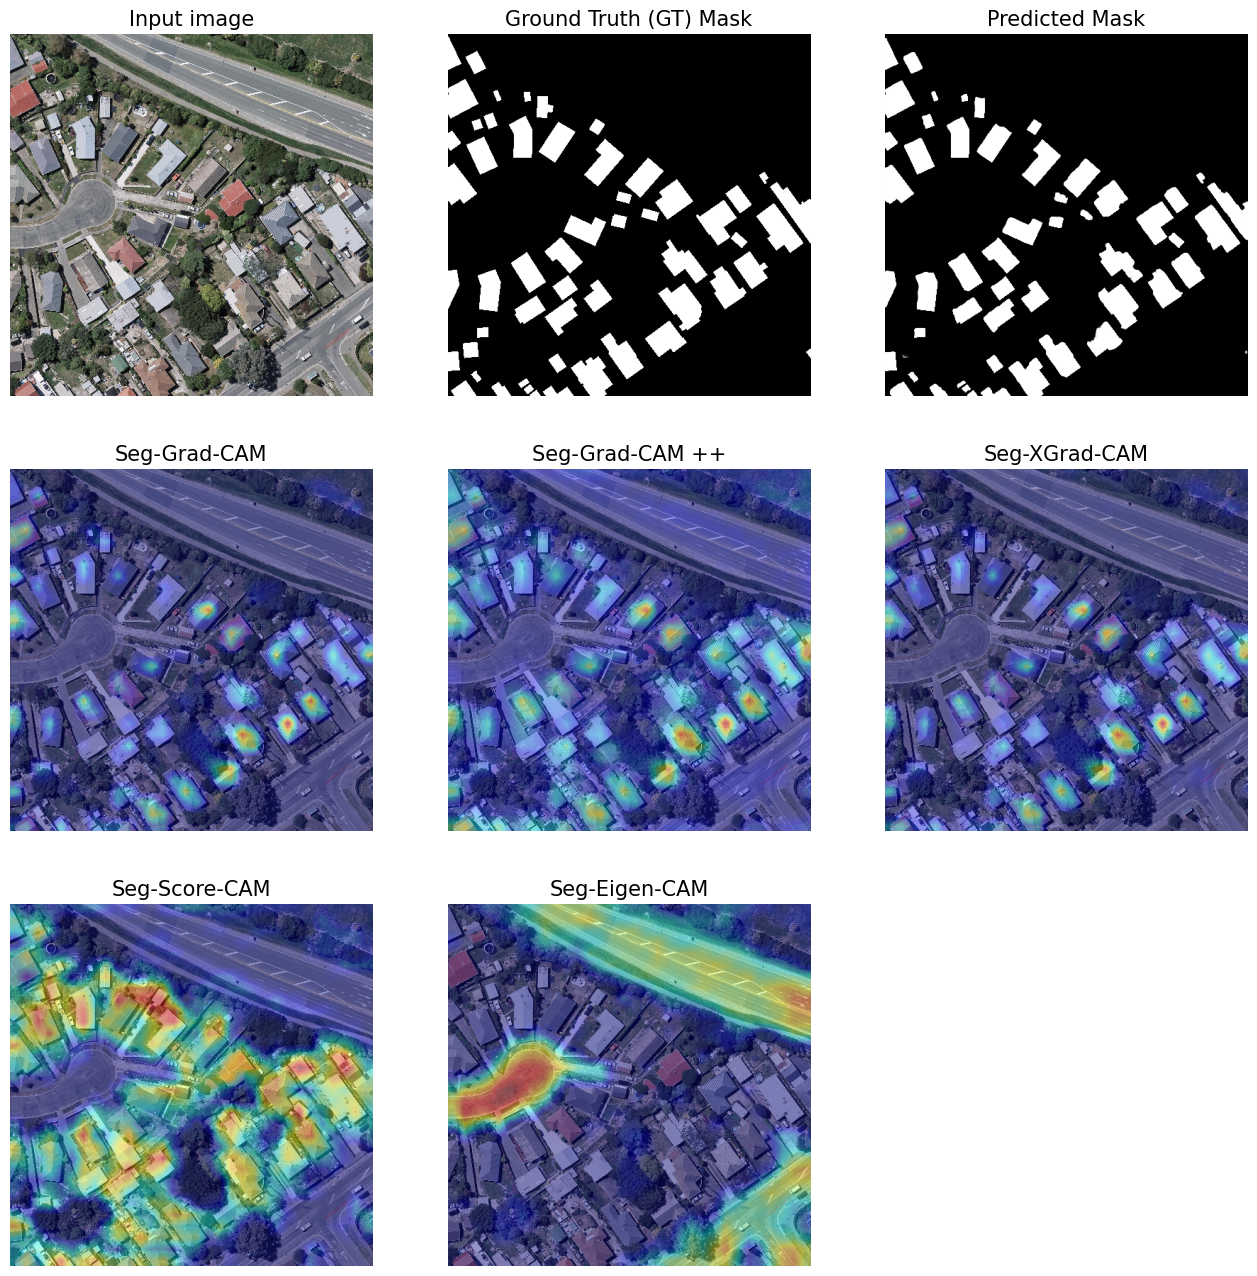

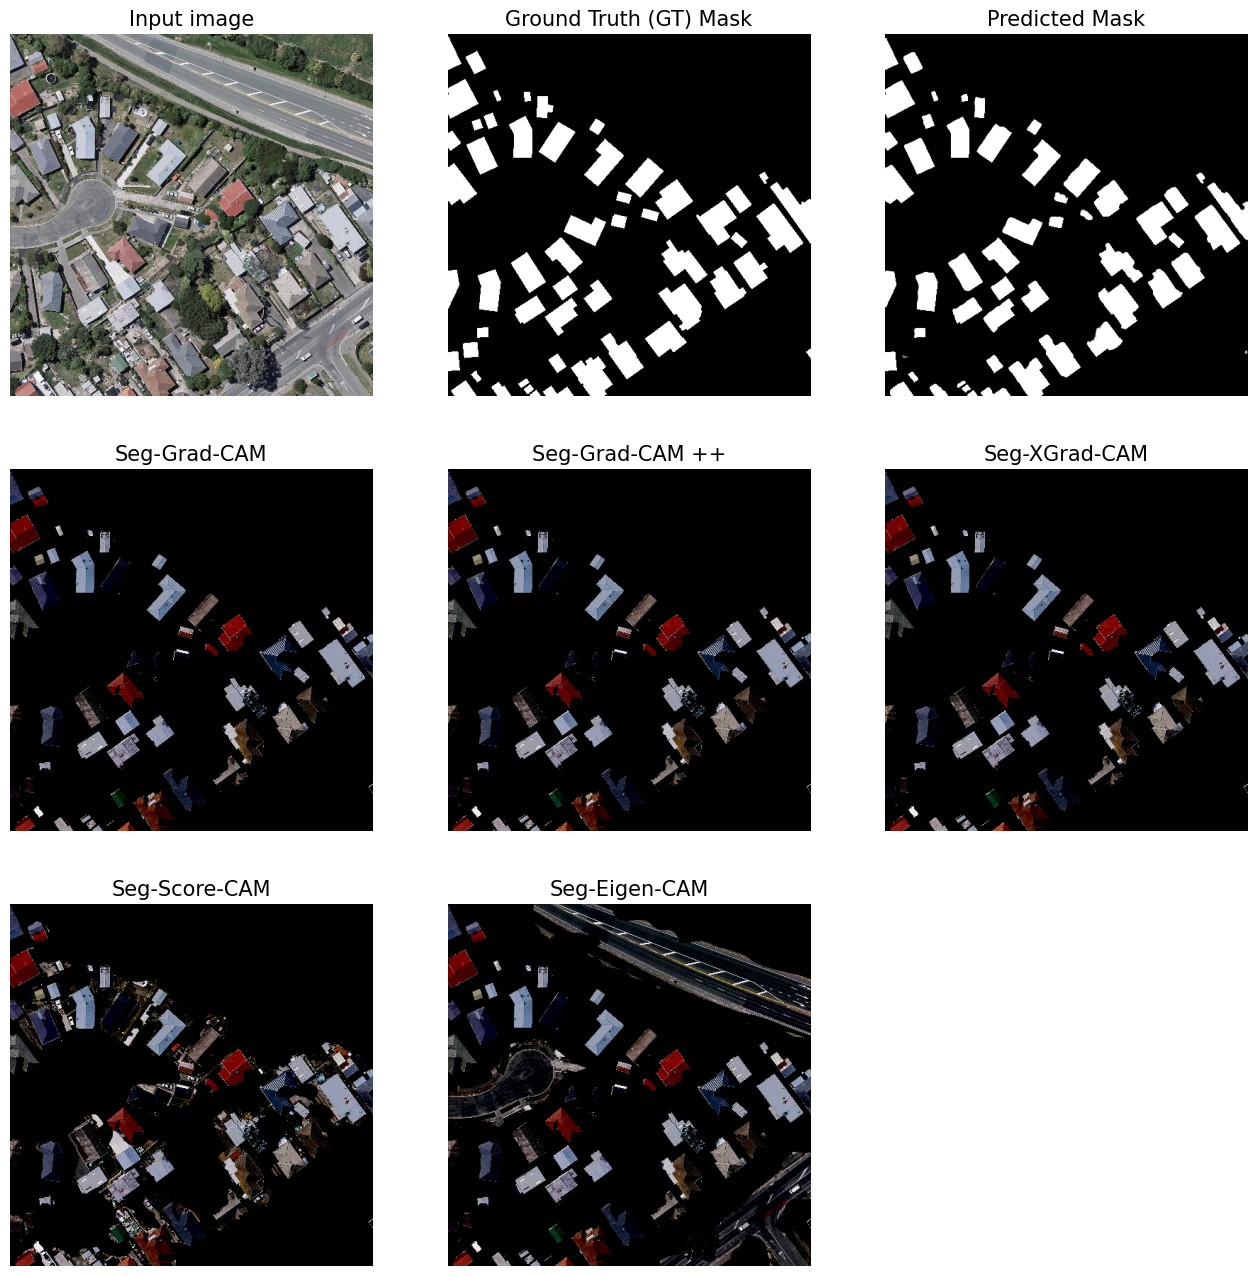

In [4]:
# Apply the adapted CAM-based Extensions on the considered dataset

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


def defaultScales():
    classes_cmap = plt.get_cmap('Spectral', 20)
    scale_fig = 2
    fonts = 15
    scatter_size = 330 * scale_fig
    return classes_cmap, scale_fig, fonts, scatter_size


def show_cam_image_whu(full_img_rgba, grayscale_cam_EX, image_weight):
    heatmap_sgc = cv2.applyColorMap(np.uint8(255 * grayscale_cam_EX), cv2.COLORMAP_JET)
    heatmap_sgc = cv2.cvtColor(heatmap_sgc, cv2.COLOR_BGR2RGB)
    heatmap_sgc = np.float32(heatmap_sgc) / 255
    if full_img.shape[-1]==4:
        heatmap_sgc = cv2.cvtColor(heatmap_sgc,cv2.COLOR_RGB2RGBA)
    Exmap_sgc = (1 - image_weight) * heatmap_sgc + image_weight * full_img_rgba
    Exmap_sgc = Exmap_sgc / np.max(Exmap_sgc)
    Exmap_sgc = np.uint8(255 * Exmap_sgc)

    return Exmap_sgc, heatmap_sgc


def prob_2_entropy(prob):
    """ convert probabilistic prediction maps to weighted self-information maps
    """
    n, c, h, w = prob.size()
    return -torch.mul(prob, torch.log2(prob + 1e-30)) / np.log2(c)


def XAI_EVAL(E_sgc, full_img_gt, model, rrp_info,target_category):

    x_sgc = totensor(E_sgc)
    # x_sgc = x_sgc.cuda()
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc,rrp_info)

    mask_tensor_sgc = y_pred_sgc[0,...]
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)

    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc


images_dir = r'C:\Users\maria\OneDrive\Desktop\Project\dataset\images'
gt_dir = r'C:\Users\maria\OneDrive\Desktop\Project\dataset\gt'




ticks = np.linspace(0, 1, 6, endpoint=True)
classes_cmap, scale_fig, fonts, scatter_size = defaultScales()




decoder_idx = 1
thres = 0.4
n_xai = 6
n_imgs = 1
target_layers =  [model.decoder.blocks[decoder_idx - 1]]
target_category = 0
XAI_method = ["grad_cam", "hires_cam", "ew_cam", "grad_cam_pp", "x_grad_cam","score_cam", "layer_cam", "eigen_cam", "eigen_grad_cam"]

image_weight = 0.006

directory_images = os.fsencode(images_dir)
directory_gt = os.fsencode(gt_dir)


number_testing_images = 0

Model_Seg_Score = np.zeros((n_imgs))
Model_Seg_Entropy = np.zeros((n_imgs))

Seg_Score_M1 = np.zeros((n_xai, n_imgs))
Seg_Entropy_M1 = np.zeros((n_xai, n_imgs))

Seg_Score_M2 = np.zeros((n_xai, n_imgs))
Seg_Entropy_M2 = np.zeros((n_xai, n_imgs))

Seg_Score_M3 = np.zeros((n_xai, n_imgs))
Seg_Entropy_M3 = np.zeros((n_xai, n_imgs))

counter = 0


for (file_img, file_gt) in zip(os.listdir(directory_images), os.listdir(directory_gt) ):

    print(file_img, file_gt)
    if file_img == file_gt:
        number_testing_images = number_testing_images + 1
        print("Testing Image: ", number_testing_images)
        filename = os.fsdecode(file_img)
        filename_gt = os.fsdecode(file_gt)
        if filename.endswith(".png") and filename_gt.endswith(".png"):
            raster_file = rio.open(f'{images_dir}/{filename}')
            full_img = raster_file.read().transpose(1,2,0)
            full_img,rrp_info = ratio_resize_pad(full_img, ratio = None)
            full_img_rgba = full_img
            print("Input Image Shape: ", full_img.shape)
            if full_img.shape[-1]==4:full_img = cv2.cvtColor(full_img,cv2.COLOR_RGBA2RGB) #WHU images are RGBA
            # read gt mask
            raster_file_gt = rio.open(f'{gt_dir}/{filename_gt}')
            full_img_gt = raster_file_gt.read().transpose(1,2,0)
            full_img_gt,rrp_info_gt = ratio_resize_pad(full_img_gt, ratio = None)
            full_img_gt = np.float32(full_img_gt) / np.max(full_img_gt)
            print("GT mask shape: ", full_img_gt.shape)


            full_img = normalize(full_img)
            x = totensor(full_img)
            # x = x.cuda()

            with torch.no_grad():
                y_pred = model(x)
                y_pred = unpad_resize(y_pred,rrp_info)



            mask_tensor = y_pred[0,...]
            print('predicated tensor shape: ', mask_tensor.shape)
            mask = y_pred[0,...].cpu().numpy().transpose(1,2,0)

            target_mask_float = np.float32(mask[:,:,target_category]) * full_img_gt
            target_Confidence_score = target_mask_float[np.nonzero(target_mask_float)]
            target_Confidence_score = np.mean(target_Confidence_score)
            print("Model Target Confidence Score: ", target_Confidence_score)

            logist_softmax_entropy = prob_2_entropy(y_pred)
            target_entropy_mask = logist_softmax_entropy[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
            target_entropy_mask_class = target_entropy_mask[:,:,target_category] * full_img_gt
            model_entropy = np.mean(target_entropy_mask_class)
            print("Model Target Entropy Score: ", model_entropy )


            targets = [SemanticSegmentationTarget(target_category, target_mask_float)]

            nan_condition = np.count_nonzero(target_mask_float)
            if nan_condition != 0:

                print('running seg-grad-cam...')
                with GRADCAM_Extensions(extension = XAI_method[0], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
                    grayscale_cam_EX = cam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX, image_weight)

                    # Evaluation
                    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
                    # M1: Background Only
                    E_sgc_M1 = full_img * np.logical_not(im_bw_sgc)[..., None]
                    [confidence_sgc_M1, entropy_sgc_M1] = XAI_EVAL(E_sgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- SGC Target Confidence Score: ", confidence_sgc_M1," Entropy Score: ", entropy_sgc_M1)

                    # M2: Highlighted Only
                    E_sgc_M2 = full_img * im_bw_sgc[..., None]
                    [confidence_sgc_M2, entropy_sgc_M2] = XAI_EVAL(E_sgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- SGC Target Confidence Score: ", confidence_sgc_M2," Entropy Score: ", entropy_sgc_M2)

                    # M3 : Highlighted + GT
                    union_gt_sgc = np.ma.mask_or(full_img_gt,im_bw_sgc)
                    E_sgc_M3 = full_img * union_gt_sgc[..., None]

                    [confidence_sgc_M3, entropy_sgc_M3] = XAI_EVAL(E_sgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- SGC Target Confidence Score: ", confidence_sgc_M3," Entropy Score: ", entropy_sgc_M3)
                #______________________________
                print('running GradCam++ ...')
                with GRADCAM_Extensions(extension = XAI_method[3], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as campp:
                    grayscale_cam_EX_Plusplus = campp(input_tensor=x, targets=targets)[0, :]
                    [Exmap_sgcpp, heatmap_sgcpp_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_Plusplus, image_weight)

                		# Evaluation
                    im_bw_sgcpp = cv2.threshold(grayscale_cam_EX_Plusplus, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_sgcpp_M1 = full_img * np.logical_not(im_bw_sgcpp)[..., None]
                    [confidence_sgcpp_M1, entropy_sgcpp_M1] = XAI_EVAL(E_sgcpp_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- SGC++ Target Confidence Score: ", confidence_sgcpp_M1," Entropy Score: ", entropy_sgcpp_M1)

										# M2: Highlighted Only
                    E_sgcpp_M2 = full_img * im_bw_sgcpp[..., None]
                    [confidence_sgcpp_M2, entropy_sgcpp_M2] = XAI_EVAL(E_sgcpp_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- SGC++ Target Confidence Score: ", confidence_sgcpp_M2," Entropy Score: ", entropy_sgcpp_M2)

              			# M3: Highlighted + GT
                    union_gt_sgcpp = np.ma.mask_or(full_img_gt,im_bw_sgcpp)
                    E_sgcpp_M3 = full_img * union_gt_sgcpp[..., None]
                    [confidence_sgcpp_M3, entropy_sgcpp_M3] = XAI_EVAL(E_sgcpp_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- SGC++ Target Confidence Score: ", confidence_sgcpp_M3," Entropy Score: ", entropy_sgcpp_M3)

								#___________________________
                print('running XGradCam...')
                with GRADCAM_Extensions(extension = XAI_method[4], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as xcam:
                    grayscale_cam_EX_X = xcam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_Xsgc, heatmap_Xsgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_X, image_weight)
										# Evaluation
                    im_bw_Xsgc = cv2.threshold(grayscale_cam_EX_X, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_Xsgc_M1 = full_img * np.logical_not(im_bw_Xsgc)[..., None]
                    [confidence_Xsgc_M1, entropy_Xsgc_M1] = XAI_EVAL(E_Xsgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- XSGC Target Confidence Score: ", confidence_Xsgc_M1," Entropy Score: ", entropy_Xsgc_M1)

										# M2: Highlighted Only
                    E_Xsgc_M2 = full_img * im_bw_Xsgc[..., None]
                    [confidence_Xsgc_M2, entropy_Xsgc_M2] = XAI_EVAL(E_Xsgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- XSGC Target Confidence Score: ", confidence_Xsgc_M2," Entropy Score: ", entropy_Xsgc_M2)

              			# M3: Highlighted + GT
                    union_gt_Xsgc = np.ma.mask_or(full_img_gt,im_bw_Xsgc)
                    E_Xsgc_M3 = full_img * union_gt_Xsgc[..., None]
                    [confidence_Xsgc_M3, entropy_Xsgc_M3] = XAI_EVAL(E_Xsgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- XSGC Target Confidence Score: ", confidence_Xsgc_M3," Entropy Score: ", entropy_Xsgc_M3)

								#___________________________
                print('running ScoreCam...')
                with GRADCAM_Extensions(extension = XAI_method[5], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as scorecam:
                    grayscale_cam_EX_Score = scorecam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_scoresgc, heatmap_scoresgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_Score, image_weight)

                    # Evaluation
                    im_bw_ssgc = cv2.threshold(grayscale_cam_EX_Score, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_ssgc_M1 = full_img * np.logical_not(im_bw_ssgc)[..., None]
                    [confidence_ssgc_M1, entropy_ssgc_M1] = XAI_EVAL(E_ssgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- Score SGC Target Confidence Score: ", confidence_ssgc_M1," Entropy Score: ", entropy_ssgc_M1)

										# M2: Highlighted Only
                    E_ssgc_M2 = full_img * im_bw_ssgc[..., None]
                    [confidence_ssgc_M2, entropy_ssgc_M2] = XAI_EVAL(E_ssgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- Score SGC Target Confidence Score: ", confidence_ssgc_M2," Entropy Score: ", entropy_ssgc_M2)

              			# M3: Highlighted + GT
                    union_gt_ssgc = np.ma.mask_or(full_img_gt,im_bw_ssgc)
                    E_ssgc_M3 = full_img * union_gt_ssgc[..., None]
                    [confidence_ssgc_M3, entropy_ssgc_M3] = XAI_EVAL(E_ssgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- Score SGC Target Confidence Score: ", confidence_ssgc_M3," Entropy Score: ", entropy_ssgc_M3)

								#__________________________
                print('running EigenCam...')
                with GRADCAM_Extensions(extension = XAI_method[7], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as ecam:
                    grayscale_cam_EX_eigen = ecam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_eigensgc, heatmap_eigensgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_eigen, image_weight)

										# Evaluation
                    im_bw_esgc = cv2.threshold(grayscale_cam_EX_eigen, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_esgc_M1 = full_img * np.logical_not(im_bw_esgc)[..., None]
                    [confidence_esgc_M1, entropy_esgc_M1] = XAI_EVAL(E_esgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- Eigen SGC Target Confidence Score: ", confidence_esgc_M1," Entropy Score: ", entropy_esgc_M1)

										# M2: Highlighted Only
                    E_esgc_M2 = full_img * im_bw_esgc[..., None]
                    [confidence_esgc_M2, entropy_esgc_M2] = XAI_EVAL(E_esgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- Eigen SGC Target Confidence Score: ", confidence_esgc_M2," Entropy Score: ", entropy_esgc_M2)

              			# M3: Highlighted + GT
                    union_gt_esgc = np.ma.mask_or(full_img_gt,im_bw_esgc)
                    E_esgc_M3 = full_img * union_gt_esgc[..., None]
                    [confidence_esgc_M3, entropy_esgc_M3] = XAI_EVAL(E_esgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- Eigen SGC Target Confidence Score: ", confidence_esgc_M3," Entropy Score: ", entropy_esgc_M3)

                Model_Seg_Score[counter] = target_Confidence_score
                Model_Seg_Entropy[counter] = model_entropy

                Seg_Score_M1[0,counter] = confidence_sgc_M1
                Seg_Score_M1[1,counter] = confidence_sgcpp_M1
                Seg_Score_M1[2,counter] = confidence_Xsgc_M1
                Seg_Score_M1[3,counter] = confidence_ssgc_M1
                Seg_Score_M1[4,counter] = confidence_esgc_M1

                Seg_Entropy_M1[0,counter] = entropy_sgc_M1
                Seg_Entropy_M1[1,counter] = entropy_sgcpp_M1
                Seg_Entropy_M1[2,counter] = entropy_Xsgc_M1
                Seg_Entropy_M1[3,counter] = entropy_ssgc_M1
                Seg_Entropy_M1[4,counter] = entropy_esgc_M1


                Seg_Score_M2[0,counter] = confidence_sgc_M2
                Seg_Score_M2[1,counter] = confidence_sgcpp_M2
                Seg_Score_M2[2,counter] = confidence_Xsgc_M2
                Seg_Score_M2[3,counter] = confidence_ssgc_M2
                Seg_Score_M2[4,counter] = confidence_esgc_M2

                Seg_Entropy_M2[0,counter] = entropy_sgc_M2
                Seg_Entropy_M2[1,counter] = entropy_sgcpp_M2
                Seg_Entropy_M2[2,counter] = entropy_Xsgc_M2
                Seg_Entropy_M2[3,counter] = entropy_ssgc_M2
                Seg_Entropy_M2[4,counter] = entropy_esgc_M2

                Seg_Score_M3[0,counter] = confidence_sgc_M3
                Seg_Score_M3[1,counter] = confidence_sgcpp_M3
                Seg_Score_M3[2,counter] = confidence_Xsgc_M3
                Seg_Score_M3[3,counter] = confidence_ssgc_M3
                Seg_Score_M3[4,counter] = confidence_esgc_M3

                Seg_Entropy_M3[0,counter] = entropy_sgc_M3
                Seg_Entropy_M3[1,counter] = entropy_sgcpp_M3
                Seg_Entropy_M3[2,counter] = entropy_Xsgc_M3
                Seg_Entropy_M3[3,counter] = entropy_ssgc_M3
                Seg_Entropy_M3[4,counter] = entropy_esgc_M3


                counter = counter + 1

                if(number_testing_images == 2):
                    break



                fig = plt.figure(figsize=(8 * scale_fig, 8 * scale_fig))

                plt.subplot(3,3,1)
                plt.axis('off')
                plt.imshow(full_img_rgba)
                plt.title('Input image', fontsize=fonts)

                plt.subplot(3,3,2)
                plt.axis('off')
                plt.imshow(full_img_gt, cmap='gray', vmin=0, vmax=1)
                plt.title('Ground Truth (GT) Mask', fontsize=fonts)

                plt.subplot(3,3,3)
                plt.axis('off')
                plt.imshow(target_mask_float,  cmap='gray', vmin=0, vmax=1)
                plt.title('Predicted Mask', fontsize=fonts)

                plt.subplot(3,3,4)
                plt.axis('off')
                plt.imshow(Exmap_sgc)
                plt.title('Seg-Grad-CAM', fontsize=fonts)

                plt.subplot(3,3,5)
                plt.axis('off')
                plt.imshow(Exmap_sgcpp)
                plt.title('Seg-Grad-CAM ++', fontsize=fonts)

                plt.subplot(3,3,6)
                plt.axis('off')
                plt.imshow(Exmap_Xsgc)
                plt.title('Seg-XGrad-CAM', fontsize=fonts)

                plt.subplot(3,3,7)
                plt.axis('off')
                plt.imshow(Exmap_scoresgc)
                plt.title('Seg-Score-CAM', fontsize=fonts)

                plt.subplot(3,3,8)
                plt.axis('off')
                plt.imshow(Exmap_eigensgc)
                plt.title('Seg-Eigen-CAM', fontsize=fonts)


                # plt.subplot(3,3,9)
                # plt.axis('off')
                # plt.imshow(Exmap_ablsgc)
                # plt.title('Seg-Ablation-CAM', fontsize=fonts)

                # Save the full figure...
                fig.savefig('./results/SegGradCam_Extensions_{}_{}.png'.format(filename,decoder_idx), bbox_inches='tight', pad_inches=0)



                fig = plt.figure(figsize=(8 * scale_fig, 8 * scale_fig))

                plt.subplot(3,3,1)
                plt.axis('off')
                plt.imshow(full_img_rgba)
                plt.title('Input image', fontsize=fonts)

                plt.subplot(3,3,2)
                plt.axis('off')
                plt.imshow(full_img_gt, cmap='gray', vmin=0, vmax=1)
                plt.title('Ground Truth (GT) Mask', fontsize=fonts)

                plt.subplot(3,3,3)
                plt.axis('off')
                plt.imshow(target_mask_float,  cmap='gray', vmin=0, vmax=1)
                plt.title('Predicted Mask', fontsize=fonts)

                plt.subplot(3,3,4)
                plt.axis('off')
                plt.imshow(E_sgc_M3)
                plt.title('Seg-Grad-CAM', fontsize=fonts)

                plt.subplot(3,3,5)
                plt.axis('off')
                plt.imshow(E_sgcpp_M3)
                plt.title('Seg-Grad-CAM ++', fontsize=fonts)

                plt.subplot(3,3,6)
                plt.axis('off')
                plt.imshow(E_Xsgc_M3)
                plt.title('Seg-XGrad-CAM', fontsize=fonts)

                plt.subplot(3,3,7)
                plt.axis('off')
                plt.imshow(E_ssgc_M3)
                plt.title('Seg-Score-CAM', fontsize=fonts)

                plt.subplot(3,3,8)
                plt.axis('off')
                plt.imshow(E_esgc_M3)
                plt.title('Seg-Eigen-CAM', fontsize=fonts)


                # plt.subplot(3,3,9)
                # plt.axis('off')
                # plt.imshow(Exmap_ablsgc)
                # plt.title('Seg-Ablation-CAM', fontsize=fonts)

                # Save the full figure...
                fig.savefig('./results/SegGradCam_Modified_M3_{}_{}.png'.format(filename,decoder_idx), bbox_inches='tight', pad_inches=0)





# Task 1: Impact of the heatmap threshold on the overall evaluation using M1, M2, and M3

In [5]:
def XAI_EVAL_M1(thres, grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category):
    """
    M1 - Background only: Mask relevant pixels (keep background), feed to model, expect drop in score
    Higher drop in classification score means better XAI method
    """
    # Create mask for relevant pixels (to be removed)
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    
    # Invert mask to keep background only
    background_mask = 1 - im_bw_sgc
    
    # Apply background mask to image
    E_sgc = full_img * background_mask[..., None]
    
    # Process through model
    x_sgc = totensor(E_sgc)
    x_sgc = x_sgc.to(device)
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

    # Calculate target class confidence score
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)
    
    # Calculate entropy
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, background_mask, E_sgc


def XAI_EVAL_M2(thres, grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category):
    """
    M2 - Highlighted only: Mask background (keep relevant pixels), feed to model, expect increase in score
    Lower drop in classification score means better XAI method
    """
    # Create mask for relevant pixels (to be kept)
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    
    # Apply mask to keep only highlighted regions
    E_sgc = full_img * im_bw_sgc[..., None]
    
    # Process through model
    x_sgc = totensor(E_sgc)
    x_sgc = x_sgc.to(device)
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

    # Calculate target class confidence score
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)
    
    # Calculate entropy
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, im_bw_sgc, E_sgc

def XAI_EVAL_M3(thres, grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category):
    """
    M3 - CAM and GT union: Combine CAM-based explanation with GT mask.
    Evaluates if XAI focuses on GT-relevant areas by assessing model output when both are emphasized.
    """
    # Threshold the CAM heatmap into binary mask
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    im_bw_sgc = im_bw_sgc.astype(np.uint8)

    # Create union mask between CAM mask and ground truth
    union_gt_sgc = np.logical_or(full_img_gt, im_bw_sgc).astype(np.float32)

    # Apply union mask to the image
    E_sgc = full_img * union_gt_sgc[..., None]
    x_sgc = totensor(E_sgc).to(device)

    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

    # Confidence
    mask_sgc = y_pred_sgc[0].cpu().numpy().transpose(1, 2, 0)
    target_mask_f = np.float32(mask_sgc[:, :, target_category]) * full_img_gt
    target_Confidence_score_sgc = np.mean(target_mask_f[np.nonzero(target_mask_f)])

    # Entropy
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0].cpu().numpy().transpose(1, 2, 0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:, :, target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = np.mean(target_entropy_mask_class_sgc)

    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, im_bw_sgc, E_sgc


In [6]:
thresholds = np.array([0.1 ,0.2 ,0.3 ,0.4 ,0.5])
XAI_methods = ["eigen_cam" ,"score_cam" ,"grad_cam" ,"grad_cam_pp", "x_grad_cam"]

method_to_index = {name: idx for idx, name in enumerate(XAI_methods)}

summary_rows = []

for method_name in XAI_methods:
    method_index = method_to_index[method_name]
    print(f"Running {method_name}...")

    try:
        with GRADCAM_Extensions(
            extension=method_name,
            model=model,
            target_layers=target_layers,
            use_cuda=torch.cuda.is_available()
        ) as cam:
            # Generate and normalize CAM
            grayscale_cam = cam(input_tensor=x, targets=targets)[0, :]
            grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())  # Normalize

            _ = show_cam_image_whu(full_img_rgba, grayscale_cam, image_weight)


            # Threshold loop
            for thresh in thresholds:
                print(f"  Threshold: {thresh}")

                # M1: Calculate confidence and entropy
                conf_m1, ent_m1, _, _ = XAI_EVAL_M1(thresh, grayscale_cam, full_img_gt, full_img, model, rrp_info, target_category)
                # M2: Calculate confidence and entropy
                conf_m2, ent_m2, _, _ = XAI_EVAL_M2(thresh, grayscale_cam, full_img_gt, full_img, model, rrp_info, target_category)
                # M3: Calculate confidence and entropy
                conf_m3, ent_m3, _, _ = XAI_EVAL_M3(thresh, grayscale_cam, full_img_gt, full_img, model, rrp_info, target_category)

                print(f"    M1 - Conf: {conf_m1:.4f}, Entropy: {ent_m1:.4f}")
                print(f"    M2 - Conf: {conf_m2:.4f}, Entropy: {ent_m2:.4f}")
                print(f"    M3 - Conf: {conf_m3:.4f}, Entropy: {ent_m3:.4f}")

                
                summary_rows.append({
                    "Method": method_name,
                    "Threshold": thresh,
    
                    "M1_Confidence": conf_m1,
                    "M1_Entropy": ent_m1,
                  
                    "M2_Confidence": conf_m2,
                    "M2_Entropy": ent_m2,
                  
                    "M3_Confidence": conf_m3,
                    "M3_Entropy": ent_m3,
                
                })
    except Exception as e:
        print(f"Error running {method_name}: {e}")


df = pd.DataFrame(summary_rows)
print(df.to_string(index=False))  

df.to_csv("xai_method_evaluation_summary.csv", index=False)
print("Saved summary to 'xai_method_evaluation_summary.csv'")


Running eigen_cam...
  Threshold: 0.1
    M1 - Conf: 0.9111, Entropy: 0.0015
    M2 - Conf: 0.2071, Entropy: 0.0030
    M3 - Conf: 0.1471, Entropy: 0.0022
  Threshold: 0.2
    M1 - Conf: 0.9118, Entropy: 0.0014
    M2 - Conf: 0.5759, Entropy: 0.0054
    M3 - Conf: 0.0595, Entropy: 0.0016
  Threshold: 0.3
    M1 - Conf: 0.9107, Entropy: 0.0014
    M2 - Conf: 0.5961, Entropy: 0.0055
    M3 - Conf: 0.0548, Entropy: 0.0016
  Threshold: 0.4
    M1 - Conf: 0.9111, Entropy: 0.0014
    M2 - Conf: 0.6564, Entropy: 0.0056
    M3 - Conf: 0.0428, Entropy: 0.0013
  Threshold: 0.5
    M1 - Conf: 0.9117, Entropy: 0.0014
    M2 - Conf: 0.7318, Entropy: 0.0056
    M3 - Conf: 0.0355, Entropy: 0.0012
Running score_cam...


100%|██████████| 32/32 [01:58<00:00,  3.71s/it]


  Threshold: 0.1
    M1 - Conf: 0.1188, Entropy: 0.0024
    M2 - Conf: 0.9044, Entropy: 0.0014
    M3 - Conf: 0.9041, Entropy: 0.0014
  Threshold: 0.2
    M1 - Conf: 0.0324, Entropy: 0.0003
    M2 - Conf: 0.8985, Entropy: 0.0014
    M3 - Conf: 0.9050, Entropy: 0.0014
  Threshold: 0.3
    M1 - Conf: 0.0399, Entropy: 0.0007
    M2 - Conf: 0.8693, Entropy: 0.0014
    M3 - Conf: 0.8899, Entropy: 0.0014
  Threshold: 0.4
    M1 - Conf: 0.1970, Entropy: 0.0016
    M2 - Conf: 0.6167, Entropy: 0.0019
    M3 - Conf: 0.7580, Entropy: 0.0020
  Threshold: 0.5
    M1 - Conf: 0.5355, Entropy: 0.0030
    M2 - Conf: 0.2341, Entropy: 0.0011
    M3 - Conf: 0.6154, Entropy: 0.0026
Running grad_cam...
  Threshold: 0.1
    M1 - Conf: 0.8785, Entropy: 0.0022
    M2 - Conf: 0.1612, Entropy: 0.0010
    M3 - Conf: 0.3580, Entropy: 0.0026
  Threshold: 0.2
    M1 - Conf: 0.8945, Entropy: 0.0019
    M2 - Conf: 0.1808, Entropy: 0.0008
    M3 - Conf: 0.0682, Entropy: 0.0015
  Threshold: 0.3
    M1 - Conf: 0.8847, En

In [7]:
df = pd.read_csv("xai_method_evaluation_summary.csv")

conf_cols = ['M1_Confidence', 'M2_Confidence', 'M3_Confidence']
entropy_cols = ['M1_Entropy', 'M2_Entropy', 'M3_Entropy']

# Normalize confidence and entropy
scaler = MinMaxScaler()
conf_norm = scaler.fit_transform(df[conf_cols])
entropy_norm = scaler.fit_transform(df[entropy_cols])

df_conf_norm = pd.DataFrame(conf_norm, columns=[col + "_norm" for col in conf_cols])
df_entropy_norm = pd.DataFrame(entropy_norm, columns=[col + "_norm" for col in entropy_cols])

# Combine normalized values with original dataframe
df = pd.concat([df, df_conf_norm, df_entropy_norm], axis=1)


best_counts = {
    "M1": defaultdict(int),
    "M2": defaultdict(int),
    "M3": defaultdict(int)
}

print("Best XAI Method per Threshold:")
for thres in thresholds:
    df_thres = df[df["Threshold"] == thres].reset_index(drop=True)

    if df_thres.empty:
        print(f"\n--- Threshold = {thres} ---")
        print("No data found for this threshold.")
        continue

    best_m1 = df_thres.loc[df_thres["M1_Confidence"].idxmin()]
    best_m2 = df_thres.loc[df_thres["M2_Confidence"].idxmax()]
    best_m3 = df_thres.loc[df_thres["M3_Entropy"].idxmin()]

    best_counts["M1"][best_m1["Method"]] += 1
    best_counts["M2"][best_m2["Method"]] += 1
    best_counts["M3"][best_m3["Method"]] += 1

    print(f"\n--- Threshold = {thres} ---")
    print("M1 Best (Low Confidence):", best_m1["Method"], f"(Conf: {best_m1['M1_Confidence']:.4f})")
    print("M2 Best (High Confidence):", best_m2["Method"], f"(Conf: {best_m2['M2_Confidence']:.4f})")
    print("M3 Best (Low Entropy):", best_m3["Method"], f"(Entropy: {best_m3['M3_Entropy']:.4f})")



Best XAI Method per Threshold:

--- Threshold = 0.1 ---
M1 Best (Low Confidence): grad_cam_pp (Conf: 0.0902)
M2 Best (High Confidence): score_cam (Conf: 0.9044)
M3 Best (Low Entropy): grad_cam_pp (Entropy: 0.0014)

--- Threshold = 0.2 ---
M1 Best (Low Confidence): score_cam (Conf: 0.0324)
M2 Best (High Confidence): score_cam (Conf: 0.8985)
M3 Best (Low Entropy): score_cam (Entropy: 0.0014)

--- Threshold = 0.3 ---
M1 Best (Low Confidence): score_cam (Conf: 0.0399)
M2 Best (High Confidence): score_cam (Conf: 0.8693)
M3 Best (Low Entropy): grad_cam (Entropy: 0.0012)

--- Threshold = 0.4 ---
M1 Best (Low Confidence): score_cam (Conf: 0.1970)
M2 Best (High Confidence): grad_cam (Conf: 0.7251)
M3 Best (Low Entropy): x_grad_cam (Entropy: 0.0011)

--- Threshold = 0.5 ---
M1 Best (Low Confidence): score_cam (Conf: 0.5355)
M2 Best (High Confidence): grad_cam (Conf: 0.7682)
M3 Best (Low Entropy): grad_cam_pp (Entropy: 0.0011)


In [8]:
df["M1_Conf_score"] = 1 - df["M1_Confidence_norm"]
df["M2_Conf_score"] = df["M2_Confidence_norm"]
df["M3_Entropy_score"] = 1 - df["M3_Entropy_norm"]
df["Overall_Score"] = df[["M1_Conf_score", "M2_Conf_score", "M3_Entropy_score"]].mean(axis=1)

df_filtered = df[df["Method"].isin(XAI_methods)]
best_per_xai = df_filtered.loc[df_filtered.groupby("Method")["Overall_Score"].idxmax()]

print("\nBest Threshold per XAI Method :")
for _, row in best_per_xai.iterrows():
    print(f"Method: {row['Method']:12s} | Threshold: {row['Threshold']} | Score: {row['Overall_Score']:.4f}")


Best Threshold per XAI Method :
Method: eigen_cam    | Threshold: 0.5 | Score: 0.5689
Method: grad_cam     | Threshold: 0.5 | Score: 0.6068
Method: grad_cam_pp  | Threshold: 0.1 | Score: 0.9232
Method: score_cam    | Threshold: 0.2 | Score: 0.9478
Method: x_grad_cam   | Threshold: 0.5 | Score: 0.6040


In [9]:
total_method_scores = Counter()

print("\nFrequency Summary of Best Methods Across All Metrics:")
for thres in thresholds:
    df_thres = df[df["Threshold"] == thres].reset_index(drop=True)

    if df_thres.empty:
        continue

    best_m1 = df_thres.loc[df_thres["M1_Confidence"].idxmin()]
    best_m2 = df_thres.loc[df_thres["M2_Confidence"].idxmax()]
    best_m3 = df_thres.loc[df_thres["M3_Entropy"].idxmin()]

  
    total_method_scores[best_m1["Method"]] += 1
    total_method_scores[best_m2["Method"]] += 1
    total_method_scores[best_m3["Method"]] += 1

for method, count in total_method_scores.most_common():
    print(f"   {method:12s}: {count} times")


best_overall_method = total_method_scores.most_common(1)[0]
print(f"\nBest Overall XAI Method: {best_overall_method[0]} with {best_overall_method[1]} appearances as best")



Frequency Summary of Best Methods Across All Metrics:
   score_cam   : 8 times
   grad_cam_pp : 3 times
   grad_cam    : 3 times
   x_grad_cam  : 1 times

Best Overall XAI Method: score_cam with 8 appearances as best


**Interpretation:**
Thresholding plays a critical role in shaping XAI evaluation. 
Lower thresholds include more of the CAM region, which favors methods with broad yet accurate saliency (like Score-CAM), while higher thresholds reward precision (favoring methods like Grad-CAM++ and XGrad-CAM).
This demonstrates that the best-performing XAI method can change with the interpretation sensitivity (threshold), and comprehensive evaluation across thresholds is essential. Overall, Score-CAM remains the most robust across metrics and thresholds.

# Task 2 : Apply M3 but using the drop in segmentation score metric

In [10]:
XAI_methods = ["grad_cam", "grad_cam_pp", "x_grad_cam", "score_cam", "eigen_cam"]
thres = 0.4  # M3 threshold

def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

def XAI_EVAL_Drop(E_sgc, full_img_gt, model, full_img, rrp_info, target_category):
    x_sgc = totensor(E_sgc)
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

        x_full = totensor(full_img)
        y_pred_full = model(x_full)
        y_pred_full = unpad_resize(y_pred_full, rrp_info)

    pred_sgc = torch.argmax(y_pred_sgc[0], dim=0).cpu().numpy()
    pred_full = torch.argmax(y_pred_full[0], dim=0).cpu().numpy()
    gt_mask = full_img_gt.astype(np.uint8)

    iou_full = compute_iou(pred_full == target_category, gt_mask == target_category)
    iou_sgc = compute_iou(pred_sgc == target_category, gt_mask == target_category)
    return iou_full - iou_sgc


drop_scores = {}


for method_name in XAI_methods:
    print(f"\nEvaluating method: {method_name}")
    
    with GRADCAM_Extensions(extension=method_name, model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
        grayscale_cam = cam(input_tensor=x, targets=targets)[0, :]

    # Normalize CAM
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

    # Threshold CAM
    _, img_bw = cv2.threshold(grayscale_cam, thres, 1, cv2.THRESH_BINARY)
    img_bw = img_bw.astype(bool)

    # M3: Union of CAM + Ground Truth
    union_mask = np.logical_or(full_img_gt.astype(bool), img_bw)
    E_img = full_img * union_mask[..., None]

    drop_result = XAI_EVAL_Drop(E_img, full_img_gt, model, full_img, rrp_info, target_category)

    print(f"{method_name} Drop Segmentation: {drop_result:.4f}")
    drop_scores[method_name] = drop_result


# Choose best method
lowest_drop_is_best = True  

if lowest_drop_is_best:
    best_method = min(drop_scores, key=drop_scores.get)
    print(f"\n Best XAI Method (Lowest Drop): {best_method} with drop {drop_scores[best_method]:.4f}")




Evaluating method: grad_cam
grad_cam Drop Segmentation: -0.2386

Evaluating method: grad_cam_pp
grad_cam_pp Drop Segmentation: -0.2407

Evaluating method: x_grad_cam
x_grad_cam Drop Segmentation: -0.2386

Evaluating method: score_cam


100%|██████████| 32/32 [02:00<00:00,  3.77s/it]


score_cam Drop Segmentation: -0.3058

Evaluating method: eigen_cam
eigen_cam Drop Segmentation: 0.0273

 Best XAI Method (Lowest Drop): score_cam with drop -0.3058



-   IoU drop measures how much model performance declines when only the important regions (as identified by XAI) are shown. 
-   A lower IoU drop means the XAI method better reflects the model’s true decision-making, indicating higher faithfulness.

# Task 3 : Repeat step 1 and 2 considering the 2nd decoder block

b'2_566.png' b'2_566.png'
Testing Image:  1
Input Image Shape:  (512, 512, 3)
GT mask shape:  (512, 512)
predicated tensor shape:  torch.Size([3, 512, 512])
Model Target Confidence Score:  0.9124947
Model Target Entropy Score:  0.0014297123
running seg-grad-cam...
M1 -- SGC Target Confidence Score:  0.8804555  Entropy Score:  0.0020837712
M2 -- SGC Target Confidence Score:  0.23861775  Entropy Score:  0.0017481018
M3 -- SGC Target Confidence Score:  0.03429066  Entropy Score:  0.0011590685
running GradCam++ ...
M1 -- SGC++ Target Confidence Score:  0.8924681  Entropy Score:  0.001824269
M2 -- SGC++ Target Confidence Score:  0.13356957  Entropy Score:  0.001783985
M3 -- SGC++ Target Confidence Score:  0.13053186  Entropy Score:  0.0021224457
running XGradCam...
M1 -- XSGC Target Confidence Score:  0.8840403  Entropy Score:  0.0021126703
M2 -- XSGC Target Confidence Score:  0.20064692  Entropy Score:  0.0011920435
M3 -- XSGC Target Confidence Score:  0.036861707  Entropy Score:  0.001225

100%|██████████| 16/16 [01:01<00:00,  3.83s/it]


M1 -- Score SGC Target Confidence Score:  0.84837353  Entropy Score:  0.0020986975
M2 -- Score SGC Target Confidence Score:  0.085603796  Entropy Score:  0.0014313852
M3 -- Score SGC Target Confidence Score:  0.6659111  Entropy Score:  0.0020904585
running EigenCam...
M1 -- Eigen SGC Target Confidence Score:  0.91334516  Entropy Score:  0.001313591
M2 -- Eigen SGC Target Confidence Score:  0.00075072795  Entropy Score:  0.00014991088
M3 -- Eigen SGC Target Confidence Score:  0.57634234  Entropy Score:  0.0031135972


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


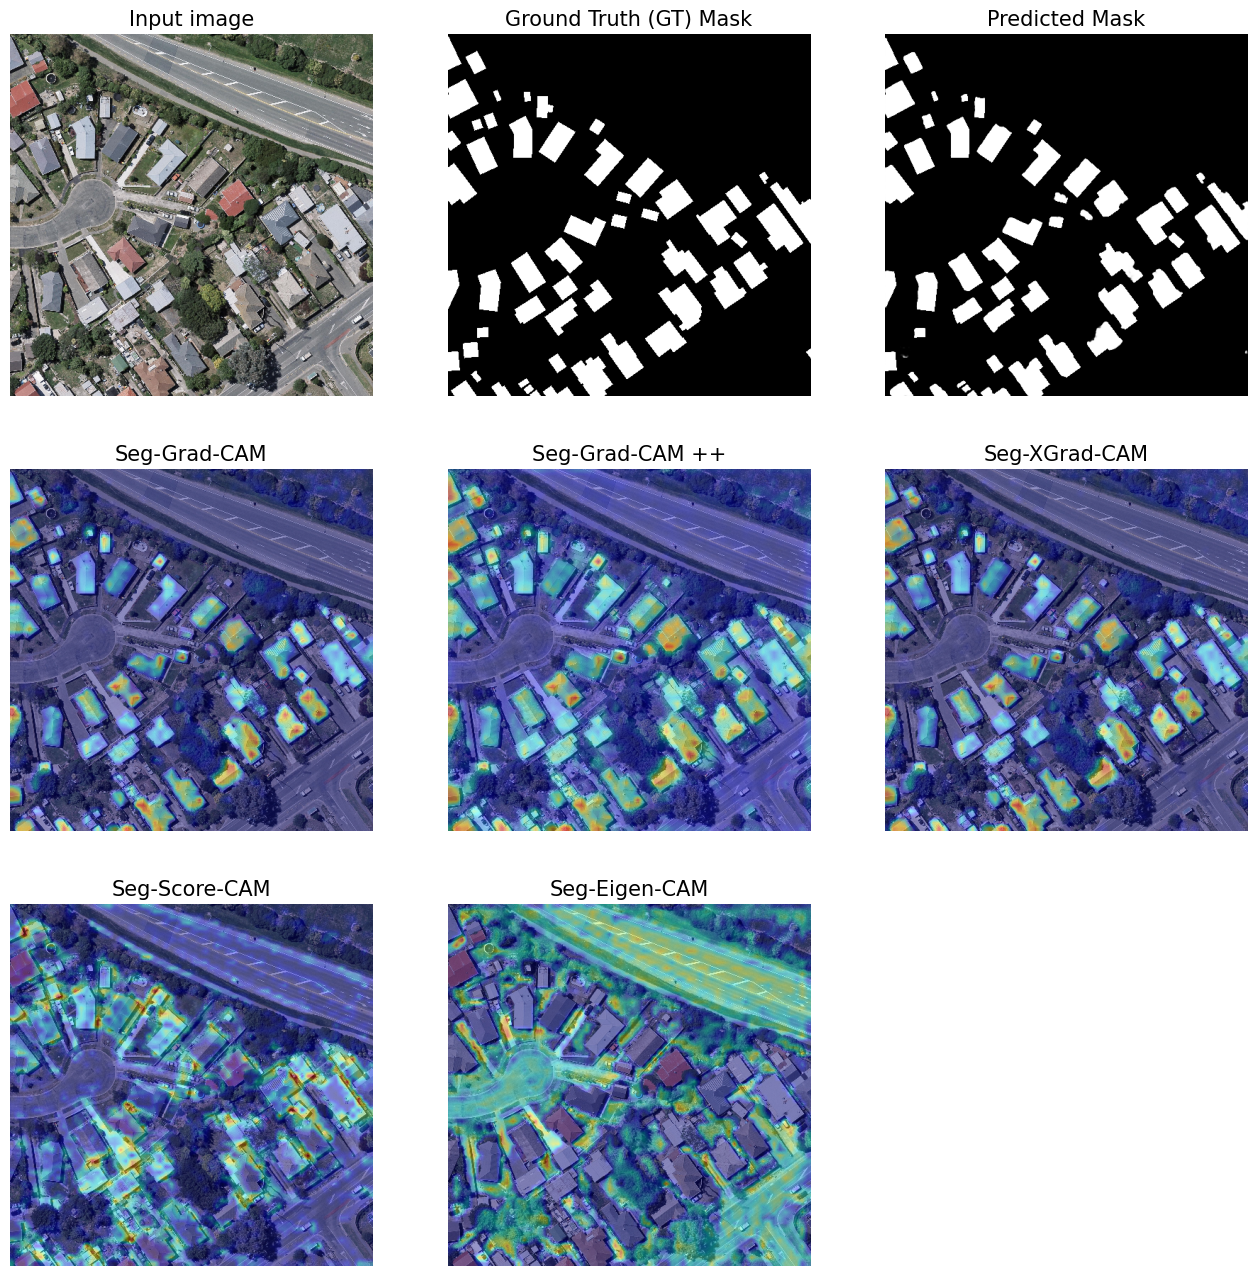

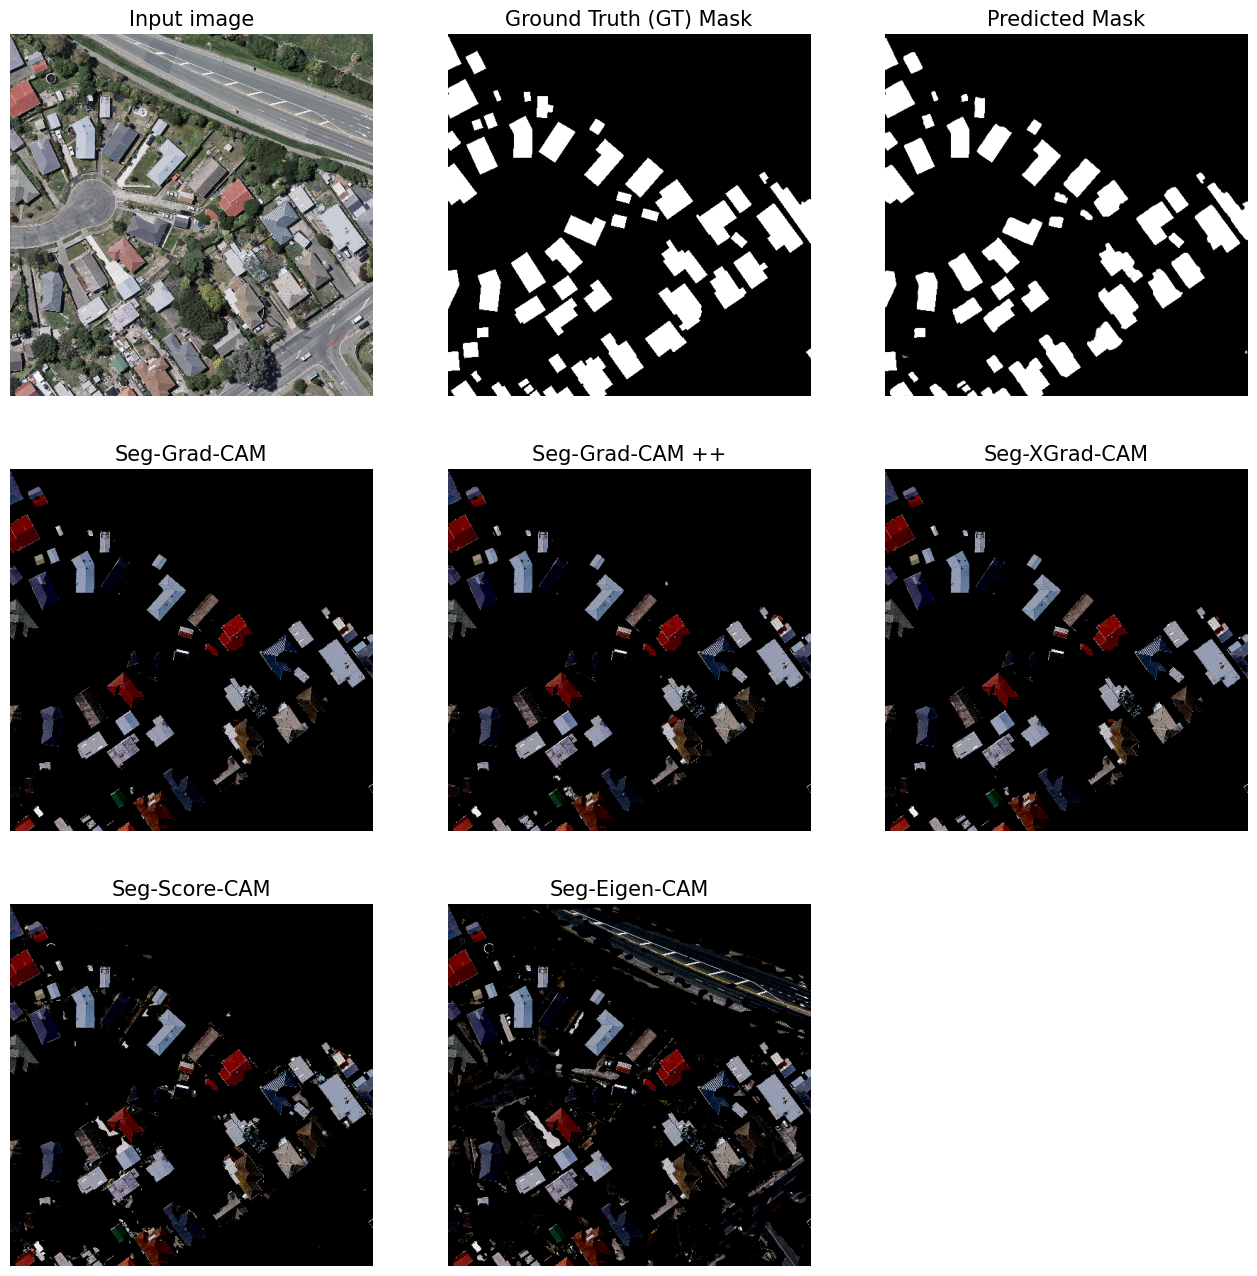

In [11]:
# Apply the adapted CAM-based Extensions on the considered dataset
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


def defaultScales():
    classes_cmap = plt.get_cmap('Spectral', 20)
    scale_fig = 2
    fonts = 15
    scatter_size = 330 * scale_fig
    return classes_cmap, scale_fig, fonts, scatter_size


def show_cam_image_whu(full_img_rgba, grayscale_cam_EX, image_weight):
    heatmap_sgc = cv2.applyColorMap(np.uint8(255 * grayscale_cam_EX), cv2.COLORMAP_JET)
    heatmap_sgc = cv2.cvtColor(heatmap_sgc, cv2.COLOR_BGR2RGB)
    heatmap_sgc = np.float32(heatmap_sgc) / 255
    if full_img.shape[-1]==4:
        heatmap_sgc = cv2.cvtColor(heatmap_sgc,cv2.COLOR_RGB2RGBA)
    Exmap_sgc = (1 - image_weight) * heatmap_sgc + image_weight * full_img_rgba
    Exmap_sgc = Exmap_sgc / np.max(Exmap_sgc)
    Exmap_sgc = np.uint8(255 * Exmap_sgc)

    return Exmap_sgc, heatmap_sgc


def prob_2_entropy(prob):
    """ convert probabilistic prediction maps to weighted self-information maps
    """
    n, c, h, w = prob.size()
    return -torch.mul(prob, torch.log2(prob + 1e-30)) / np.log2(c)


def XAI_EVAL(E_sgc, full_img_gt, model, rrp_info,target_category):

    x_sgc = totensor(E_sgc)
    # x_sgc = x_sgc.cuda()
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc,rrp_info)

    mask_tensor_sgc = y_pred_sgc[0,...]
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)

    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc


images_dir = r'C:\Users\maria\OneDrive\Desktop\Project\dataset\images'
gt_dir = r'C:\Users\maria\OneDrive\Desktop\Project\dataset\gt'




ticks = np.linspace(0, 1, 6, endpoint=True)
classes_cmap, scale_fig, fonts, scatter_size = defaultScales()




decoder_idx = 2
thres = 0.4
n_xai = 6
n_imgs = 1
target_layers =  [model.decoder.blocks[decoder_idx - 1]]
target_category = 0
XAI_method = ["grad_cam", "hires_cam", "ew_cam", "grad_cam_pp", "x_grad_cam","score_cam", "layer_cam", "eigen_cam", "eigen_grad_cam"]

image_weight = 0.006

directory_images = os.fsencode(images_dir)
directory_gt = os.fsencode(gt_dir)


number_testing_images = 0

Model_Seg_Score = np.zeros((n_imgs))
Model_Seg_Entropy = np.zeros((n_imgs))

Seg_Score_M1 = np.zeros((n_xai, n_imgs))
Seg_Entropy_M1 = np.zeros((n_xai, n_imgs))

Seg_Score_M2 = np.zeros((n_xai, n_imgs))
Seg_Entropy_M2 = np.zeros((n_xai, n_imgs))

Seg_Score_M3 = np.zeros((n_xai, n_imgs))
Seg_Entropy_M3 = np.zeros((n_xai, n_imgs))

counter = 0


for (file_img, file_gt) in zip(os.listdir(directory_images), os.listdir(directory_gt) ):

    print(file_img, file_gt)
    if file_img == file_gt:
        number_testing_images = number_testing_images + 1
        print("Testing Image: ", number_testing_images)
        filename = os.fsdecode(file_img)
        filename_gt = os.fsdecode(file_gt)
        if filename.endswith(".png") and filename_gt.endswith(".png"):
            raster_file = rio.open(f'{images_dir}/{filename}')
            full_img = raster_file.read().transpose(1,2,0)
            full_img,rrp_info = ratio_resize_pad(full_img, ratio = None)
            full_img_rgba = full_img
            print("Input Image Shape: ", full_img.shape)
            if full_img.shape[-1]==4:full_img = cv2.cvtColor(full_img,cv2.COLOR_RGBA2RGB) #WHU images are RGBA
            # read gt mask
            raster_file_gt = rio.open(f'{gt_dir}/{filename_gt}')
            full_img_gt = raster_file_gt.read().transpose(1,2,0)
            full_img_gt,rrp_info_gt = ratio_resize_pad(full_img_gt, ratio = None)
            full_img_gt = np.float32(full_img_gt) / np.max(full_img_gt)
            print("GT mask shape: ", full_img_gt.shape)


            full_img = normalize(full_img)
            x = totensor(full_img)
            # x = x.cuda()

            with torch.no_grad():
                y_pred = model(x)
                y_pred = unpad_resize(y_pred,rrp_info)



            mask_tensor = y_pred[0,...]
            print('predicated tensor shape: ', mask_tensor.shape)
            mask = y_pred[0,...].cpu().numpy().transpose(1,2,0)

            target_mask_float = np.float32(mask[:,:,target_category]) * full_img_gt
            target_Confidence_score = target_mask_float[np.nonzero(target_mask_float)]
            target_Confidence_score = np.mean(target_Confidence_score)
            print("Model Target Confidence Score: ", target_Confidence_score)

            logist_softmax_entropy = prob_2_entropy(y_pred)
            target_entropy_mask = logist_softmax_entropy[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
            target_entropy_mask_class = target_entropy_mask[:,:,target_category] * full_img_gt
            model_entropy = np.mean(target_entropy_mask_class)
            print("Model Target Entropy Score: ", model_entropy )


            targets = [SemanticSegmentationTarget(target_category, target_mask_float)]

            nan_condition = np.count_nonzero(target_mask_float)
            if nan_condition != 0:

                print('running seg-grad-cam...')
                with GRADCAM_Extensions(extension = XAI_method[0], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
                    grayscale_cam_EX = cam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX, image_weight)

                    # Evaluation
                    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
                    # M1: Background Only
                    E_sgc_M1 = full_img * np.logical_not(im_bw_sgc)[..., None]
                    [confidence_sgc_M1, entropy_sgc_M1] = XAI_EVAL(E_sgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- SGC Target Confidence Score: ", confidence_sgc_M1," Entropy Score: ", entropy_sgc_M1)

                    # M2: Highlighted Only
                    E_sgc_M2 = full_img * im_bw_sgc[..., None]
                    [confidence_sgc_M2, entropy_sgc_M2] = XAI_EVAL(E_sgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- SGC Target Confidence Score: ", confidence_sgc_M2," Entropy Score: ", entropy_sgc_M2)

                    # M3 : Highlighted + GT
                    union_gt_sgc = np.ma.mask_or(full_img_gt,im_bw_sgc)
                    E_sgc_M3 = full_img * union_gt_sgc[..., None]

                    [confidence_sgc_M3, entropy_sgc_M3] = XAI_EVAL(E_sgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- SGC Target Confidence Score: ", confidence_sgc_M3," Entropy Score: ", entropy_sgc_M3)
                #______________________________
                print('running GradCam++ ...')
                with GRADCAM_Extensions(extension = XAI_method[3], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as campp:
                    grayscale_cam_EX_Plusplus = campp(input_tensor=x, targets=targets)[0, :]
                    [Exmap_sgcpp, heatmap_sgcpp_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_Plusplus, image_weight)

                		# Evaluation
                    im_bw_sgcpp = cv2.threshold(grayscale_cam_EX_Plusplus, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_sgcpp_M1 = full_img * np.logical_not(im_bw_sgcpp)[..., None]
                    [confidence_sgcpp_M1, entropy_sgcpp_M1] = XAI_EVAL(E_sgcpp_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- SGC++ Target Confidence Score: ", confidence_sgcpp_M1," Entropy Score: ", entropy_sgcpp_M1)

										# M2: Highlighted Only
                    E_sgcpp_M2 = full_img * im_bw_sgcpp[..., None]
                    [confidence_sgcpp_M2, entropy_sgcpp_M2] = XAI_EVAL(E_sgcpp_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- SGC++ Target Confidence Score: ", confidence_sgcpp_M2," Entropy Score: ", entropy_sgcpp_M2)

              			# M3: Highlighted + GT
                    union_gt_sgcpp = np.ma.mask_or(full_img_gt,im_bw_sgcpp)
                    E_sgcpp_M3 = full_img * union_gt_sgcpp[..., None]
                    [confidence_sgcpp_M3, entropy_sgcpp_M3] = XAI_EVAL(E_sgcpp_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- SGC++ Target Confidence Score: ", confidence_sgcpp_M3," Entropy Score: ", entropy_sgcpp_M3)

								#___________________________
                print('running XGradCam...')
                with GRADCAM_Extensions(extension = XAI_method[4], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as xcam:
                    grayscale_cam_EX_X = xcam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_Xsgc, heatmap_Xsgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_X, image_weight)
										# Evaluation
                    im_bw_Xsgc = cv2.threshold(grayscale_cam_EX_X, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_Xsgc_M1 = full_img * np.logical_not(im_bw_Xsgc)[..., None]
                    [confidence_Xsgc_M1, entropy_Xsgc_M1] = XAI_EVAL(E_Xsgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- XSGC Target Confidence Score: ", confidence_Xsgc_M1," Entropy Score: ", entropy_Xsgc_M1)

										# M2: Highlighted Only
                    E_Xsgc_M2 = full_img * im_bw_Xsgc[..., None]
                    [confidence_Xsgc_M2, entropy_Xsgc_M2] = XAI_EVAL(E_Xsgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- XSGC Target Confidence Score: ", confidence_Xsgc_M2," Entropy Score: ", entropy_Xsgc_M2)

              			# M3: Highlighted + GT
                    union_gt_Xsgc = np.ma.mask_or(full_img_gt,im_bw_Xsgc)
                    E_Xsgc_M3 = full_img * union_gt_Xsgc[..., None]
                    [confidence_Xsgc_M3, entropy_Xsgc_M3] = XAI_EVAL(E_Xsgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- XSGC Target Confidence Score: ", confidence_Xsgc_M3," Entropy Score: ", entropy_Xsgc_M3)

								#___________________________
                print('running ScoreCam...')
                with GRADCAM_Extensions(extension = XAI_method[5], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as scorecam:
                    grayscale_cam_EX_Score = scorecam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_scoresgc, heatmap_scoresgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_Score, image_weight)

                    # Evaluation
                    im_bw_ssgc = cv2.threshold(grayscale_cam_EX_Score, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_ssgc_M1 = full_img * np.logical_not(im_bw_ssgc)[..., None]
                    [confidence_ssgc_M1, entropy_ssgc_M1] = XAI_EVAL(E_ssgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- Score SGC Target Confidence Score: ", confidence_ssgc_M1," Entropy Score: ", entropy_ssgc_M1)

										# M2: Highlighted Only
                    E_ssgc_M2 = full_img * im_bw_ssgc[..., None]
                    [confidence_ssgc_M2, entropy_ssgc_M2] = XAI_EVAL(E_ssgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- Score SGC Target Confidence Score: ", confidence_ssgc_M2," Entropy Score: ", entropy_ssgc_M2)

              			# M3: Highlighted + GT
                    union_gt_ssgc = np.ma.mask_or(full_img_gt,im_bw_ssgc)
                    E_ssgc_M3 = full_img * union_gt_ssgc[..., None]
                    [confidence_ssgc_M3, entropy_ssgc_M3] = XAI_EVAL(E_ssgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- Score SGC Target Confidence Score: ", confidence_ssgc_M3," Entropy Score: ", entropy_ssgc_M3)

								#__________________________
                print('running EigenCam...')
                with GRADCAM_Extensions(extension = XAI_method[7], model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as ecam:
                    grayscale_cam_EX_eigen = ecam(input_tensor=x, targets=targets)[0, :]
                    [Exmap_eigensgc, heatmap_eigensgc_rgba] = show_cam_image_whu(full_img_rgba, grayscale_cam_EX_eigen, image_weight)

										# Evaluation
                    im_bw_esgc = cv2.threshold(grayscale_cam_EX_eigen, thres, 1, cv2.THRESH_BINARY)[1]

                    # M1: Background Only
                    E_esgc_M1 = full_img * np.logical_not(im_bw_esgc)[..., None]
                    [confidence_esgc_M1, entropy_esgc_M1] = XAI_EVAL(E_esgc_M1, full_img_gt, model, rrp_info,target_category)
                    print("M1 -- Eigen SGC Target Confidence Score: ", confidence_esgc_M1," Entropy Score: ", entropy_esgc_M1)

										# M2: Highlighted Only
                    E_esgc_M2 = full_img * im_bw_esgc[..., None]
                    [confidence_esgc_M2, entropy_esgc_M2] = XAI_EVAL(E_esgc_M2, full_img_gt, model, rrp_info,target_category)
                    print("M2 -- Eigen SGC Target Confidence Score: ", confidence_esgc_M2," Entropy Score: ", entropy_esgc_M2)

              			# M3: Highlighted + GT
                    union_gt_esgc = np.ma.mask_or(full_img_gt,im_bw_esgc)
                    E_esgc_M3 = full_img * union_gt_esgc[..., None]
                    [confidence_esgc_M3, entropy_esgc_M3] = XAI_EVAL(E_esgc_M3, full_img_gt, model, rrp_info,target_category)
                    print("M3 -- Eigen SGC Target Confidence Score: ", confidence_esgc_M3," Entropy Score: ", entropy_esgc_M3)

                Model_Seg_Score[counter] = target_Confidence_score
                Model_Seg_Entropy[counter] = model_entropy

                Seg_Score_M1[0,counter] = confidence_sgc_M1
                Seg_Score_M1[1,counter] = confidence_sgcpp_M1
                Seg_Score_M1[2,counter] = confidence_Xsgc_M1
                Seg_Score_M1[3,counter] = confidence_ssgc_M1
                Seg_Score_M1[4,counter] = confidence_esgc_M1

                Seg_Entropy_M1[0,counter] = entropy_sgc_M1
                Seg_Entropy_M1[1,counter] = entropy_sgcpp_M1
                Seg_Entropy_M1[2,counter] = entropy_Xsgc_M1
                Seg_Entropy_M1[3,counter] = entropy_ssgc_M1
                Seg_Entropy_M1[4,counter] = entropy_esgc_M1


                Seg_Score_M2[0,counter] = confidence_sgc_M2
                Seg_Score_M2[1,counter] = confidence_sgcpp_M2
                Seg_Score_M2[2,counter] = confidence_Xsgc_M2
                Seg_Score_M2[3,counter] = confidence_ssgc_M2
                Seg_Score_M2[4,counter] = confidence_esgc_M2

                Seg_Entropy_M2[0,counter] = entropy_sgc_M2
                Seg_Entropy_M2[1,counter] = entropy_sgcpp_M2
                Seg_Entropy_M2[2,counter] = entropy_Xsgc_M2
                Seg_Entropy_M2[3,counter] = entropy_ssgc_M2
                Seg_Entropy_M2[4,counter] = entropy_esgc_M2

                Seg_Score_M3[0,counter] = confidence_sgc_M3
                Seg_Score_M3[1,counter] = confidence_sgcpp_M3
                Seg_Score_M3[2,counter] = confidence_Xsgc_M3
                Seg_Score_M3[3,counter] = confidence_ssgc_M3
                Seg_Score_M3[4,counter] = confidence_esgc_M3

                Seg_Entropy_M3[0,counter] = entropy_sgc_M3
                Seg_Entropy_M3[1,counter] = entropy_sgcpp_M3
                Seg_Entropy_M3[2,counter] = entropy_Xsgc_M3
                Seg_Entropy_M3[3,counter] = entropy_ssgc_M3
                Seg_Entropy_M3[4,counter] = entropy_esgc_M3


                counter = counter + 1

                if(number_testing_images == 2):
                    break



                fig = plt.figure(figsize=(8 * scale_fig, 8 * scale_fig))

                plt.subplot(3,3,1)
                plt.axis('off')
                plt.imshow(full_img_rgba)
                plt.title('Input image', fontsize=fonts)

                plt.subplot(3,3,2)
                plt.axis('off')
                plt.imshow(full_img_gt, cmap='gray', vmin=0, vmax=1)
                plt.title('Ground Truth (GT) Mask', fontsize=fonts)

                plt.subplot(3,3,3)
                plt.axis('off')
                plt.imshow(target_mask_float,  cmap='gray', vmin=0, vmax=1)
                plt.title('Predicted Mask', fontsize=fonts)

                plt.subplot(3,3,4)
                plt.axis('off')
                plt.imshow(Exmap_sgc)
                plt.title('Seg-Grad-CAM', fontsize=fonts)

                plt.subplot(3,3,5)
                plt.axis('off')
                plt.imshow(Exmap_sgcpp)
                plt.title('Seg-Grad-CAM ++', fontsize=fonts)

                plt.subplot(3,3,6)
                plt.axis('off')
                plt.imshow(Exmap_Xsgc)
                plt.title('Seg-XGrad-CAM', fontsize=fonts)

                plt.subplot(3,3,7)
                plt.axis('off')
                plt.imshow(Exmap_scoresgc)
                plt.title('Seg-Score-CAM', fontsize=fonts)

                plt.subplot(3,3,8)
                plt.axis('off')
                plt.imshow(Exmap_eigensgc)
                plt.title('Seg-Eigen-CAM', fontsize=fonts)


                # plt.subplot(3,3,9)
                # plt.axis('off')
                # plt.imshow(Exmap_ablsgc)
                # plt.title('Seg-Ablation-CAM', fontsize=fonts)

                # Save the full figure...
                fig.savefig('./results/SegGradCam_Extensions_{}_{}.png'.format(filename,decoder_idx), bbox_inches='tight', pad_inches=0)



                fig = plt.figure(figsize=(8 * scale_fig, 8 * scale_fig))

                plt.subplot(3,3,1)
                plt.axis('off')
                plt.imshow(full_img_rgba)
                plt.title('Input image', fontsize=fonts)

                plt.subplot(3,3,2)
                plt.axis('off')
                plt.imshow(full_img_gt, cmap='gray', vmin=0, vmax=1)
                plt.title('Ground Truth (GT) Mask', fontsize=fonts)

                plt.subplot(3,3,3)
                plt.axis('off')
                plt.imshow(target_mask_float,  cmap='gray', vmin=0, vmax=1)
                plt.title('Predicted Mask', fontsize=fonts)

                plt.subplot(3,3,4)
                plt.axis('off')
                plt.imshow(E_sgc_M3)
                plt.title('Seg-Grad-CAM', fontsize=fonts)

                plt.subplot(3,3,5)
                plt.axis('off')
                plt.imshow(E_sgcpp_M3)
                plt.title('Seg-Grad-CAM ++', fontsize=fonts)

                plt.subplot(3,3,6)
                plt.axis('off')
                plt.imshow(E_Xsgc_M3)
                plt.title('Seg-XGrad-CAM', fontsize=fonts)

                plt.subplot(3,3,7)
                plt.axis('off')
                plt.imshow(E_ssgc_M3)
                plt.title('Seg-Score-CAM', fontsize=fonts)

                plt.subplot(3,3,8)
                plt.axis('off')
                plt.imshow(E_esgc_M3)
                plt.title('Seg-Eigen-CAM', fontsize=fonts)


                # plt.subplot(3,3,9)
                # plt.axis('off')
                # plt.imshow(Exmap_ablsgc)
                # plt.title('Seg-Ablation-CAM', fontsize=fonts)

                # Save the full figure...
                fig.savefig('./results/SegGradCam_Modified_M3_{}_{}.png'.format(filename,decoder_idx), bbox_inches='tight', pad_inches=0)





In [12]:
def XAI_EVAL_M1(thres, grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category):
    """
    M1 - Background only: Mask relevant pixels (keep background), feed to model, expect drop in score
    Higher drop in classification score means better XAI method
    """
    # Create mask for relevant pixels (to be removed)
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    
    # Invert mask to keep background only
    background_mask = 1 - im_bw_sgc
    
    # Apply background mask to image
    E_sgc = full_img * background_mask[..., None]
    
    # Process through model
    x_sgc = totensor(E_sgc)
    x_sgc = x_sgc.to(device)
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

    # Calculate target class confidence score
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)
    
    # Calculate entropy
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, background_mask, E_sgc


def XAI_EVAL_M2(thres, grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category):
    """
    M2 - Highlighted only: Mask background (keep relevant pixels), feed to model, expect increase in score
    Lower drop in classification score means better XAI method
    """
    # Create mask for relevant pixels (to be kept)
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    
    # Apply mask to keep only highlighted regions
    E_sgc = full_img * im_bw_sgc[..., None]
    
    # Process through model
    x_sgc = totensor(E_sgc)
    x_sgc = x_sgc.to(device)
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

    # Calculate target class confidence score
    mask_sgc = y_pred_sgc[0,...].cpu().numpy().transpose(1,2,0)
    target_mask_f = np.float32(mask_sgc[:,:,target_category]) * full_img_gt
    target_Confidence_score = target_mask_f[np.nonzero(target_mask_f)]
    target_Confidence_score_sgc = np.mean(target_Confidence_score)
    
    # Calculate entropy
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0, :, :, :].detach().cpu().numpy().transpose(1,2,0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:,:,target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = (np.mean(target_entropy_mask_class_sgc))
    
    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, im_bw_sgc, E_sgc

def XAI_EVAL_M3(thres, grayscale_cam_EX, full_img_gt, full_img, model, rrp_info, target_category):
    """
    M3 - CAM and GT union: Combine CAM-based explanation with GT mask.
    Evaluates if XAI focuses on GT-relevant areas by assessing model output when both are emphasized.
    """
    # Threshold the CAM heatmap into binary mask
    im_bw_sgc = cv2.threshold(grayscale_cam_EX, thres, 1, cv2.THRESH_BINARY)[1]
    im_bw_sgc = im_bw_sgc.astype(np.uint8)

    # Create union mask between CAM mask and ground truth
    union_gt_sgc = np.logical_or(full_img_gt, im_bw_sgc).astype(np.float32)

    # Apply union mask to the image
    E_sgc = full_img * union_gt_sgc[..., None]
    x_sgc = totensor(E_sgc).to(device)

    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

    # Confidence
    mask_sgc = y_pred_sgc[0].cpu().numpy().transpose(1, 2, 0)
    target_mask_f = np.float32(mask_sgc[:, :, target_category]) * full_img_gt
    target_Confidence_score_sgc = np.mean(target_mask_f[np.nonzero(target_mask_f)])

    # Entropy
    logist_softmax_entropy_sgc = prob_2_entropy(y_pred_sgc)
    target_entropy_mask_sgc = logist_softmax_entropy_sgc[0].cpu().numpy().transpose(1, 2, 0)
    target_entropy_mask_class_sgc = target_entropy_mask_sgc[:, :, target_category] * full_img_gt
    target_entropy_mask_class_sgc_sc = np.mean(target_entropy_mask_class_sgc)

    return target_Confidence_score_sgc, target_entropy_mask_class_sgc_sc, im_bw_sgc, E_sgc


In [13]:
thresholds = np.array([0.1 ,0.2 ,0.3 ,0.4 ,0.5])
XAI_methods = ["eigen_cam" ,"score_cam" ,"grad_cam" ,"grad_cam_pp", "x_grad_cam"]

method_to_index = {name: idx for idx, name in enumerate(XAI_methods)}

summary_rows = []

for method_name in XAI_methods:
    method_index = method_to_index[method_name]
    print(f"Running {method_name}...")

    try:
        with GRADCAM_Extensions(
            extension=method_name,
            model=model,
            target_layers=target_layers,
            use_cuda=torch.cuda.is_available()
        ) as cam:
            # Generate and normalize CAM
            grayscale_cam = cam(input_tensor=x, targets=targets)[0, :]
            grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())  # Normalize

            _ = show_cam_image_whu(full_img_rgba, grayscale_cam, image_weight)

            # Baseline prediction (full image)
            with torch.no_grad():
                y_pred_baseline = model(x.to(device))
                y_pred_baseline = unpad_resize(y_pred_baseline, rrp_info)

        

            # Threshold loop
            for thresh in thresholds:
                print(f"  Threshold: {thresh}")

                # M1: Calculate confidence and entropy
                conf_m1, ent_m1, _, _ = XAI_EVAL_M1(thresh, grayscale_cam, full_img_gt, full_img, model, rrp_info, target_category)
                # M2: Calculate confidence and entropy
                conf_m2, ent_m2, _, _ = XAI_EVAL_M2(thresh, grayscale_cam, full_img_gt, full_img, model, rrp_info, target_category)
                # M3: Calculate confidence and entropy
                conf_m3, ent_m3, _, _ = XAI_EVAL_M3(thresh, grayscale_cam, full_img_gt, full_img, model, rrp_info, target_category)

                print(f"    M1 - Conf: {conf_m1:.4f}, Entropy: {ent_m1:.4f}")
                print(f"    M2 - Conf: {conf_m2:.4f}, Entropy: {ent_m2:.4f}")
                print(f"    M3 - Conf: {conf_m3:.4f}, Entropy: {ent_m3:.4f}")

                
                summary_rows.append({
                    "Method": method_name,
                    "Threshold": thresh,
                
                    "M1_Confidence": conf_m1,
                    "M1_Entropy": ent_m1,
                  
                    "M2_Confidence": conf_m2,
                    "M2_Entropy": ent_m2,
                  
                    "M3_Confidence": conf_m3,
                    "M3_Entropy": ent_m3,
                
                })
    except Exception as e:
        print(f"Error running {method_name}: {e}")


df = pd.DataFrame(summary_rows)
print(df.to_string(index=False))  

df.to_csv("xai_method_evaluation_decoder.csv", index=False)
print("Saved summary to 'xai_method_evaluation_decoder.csv'")


Running eigen_cam...
  Threshold: 0.1
    M1 - Conf: 0.7404, Entropy: 0.0024
    M2 - Conf: 0.5393, Entropy: 0.0045
    M3 - Conf: 0.8997, Entropy: 0.0017
  Threshold: 0.2
    M1 - Conf: 0.8923, Entropy: 0.0014
    M2 - Conf: 0.1704, Entropy: 0.0031
    M3 - Conf: 0.8551, Entropy: 0.0022
  Threshold: 0.3
    M1 - Conf: 0.9073, Entropy: 0.0013
    M2 - Conf: 0.0363, Entropy: 0.0007
    M3 - Conf: 0.7492, Entropy: 0.0034
  Threshold: 0.4
    M1 - Conf: 0.9133, Entropy: 0.0013
    M2 - Conf: 0.0008, Entropy: 0.0001
    M3 - Conf: 0.5763, Entropy: 0.0031
  Threshold: 0.5
    M1 - Conf: 0.9134, Entropy: 0.0014
    M2 - Conf: 0.0028, Entropy: 0.0002
    M3 - Conf: 0.4499, Entropy: 0.0030
Running score_cam...


100%|██████████| 16/16 [01:00<00:00,  3.81s/it]


  Threshold: 0.1
    M1 - Conf: 0.0190, Entropy: 0.0007
    M2 - Conf: 0.8584, Entropy: 0.0015
    M3 - Conf: 0.9015, Entropy: 0.0013
  Threshold: 0.2
    M1 - Conf: 0.1919, Entropy: 0.0018
    M2 - Conf: 0.6879, Entropy: 0.0024
    M3 - Conf: 0.8726, Entropy: 0.0013
  Threshold: 0.3
    M1 - Conf: 0.6194, Entropy: 0.0027
    M2 - Conf: 0.3260, Entropy: 0.0023
    M3 - Conf: 0.8225, Entropy: 0.0018
  Threshold: 0.4
    M1 - Conf: 0.8484, Entropy: 0.0021
    M2 - Conf: 0.0856, Entropy: 0.0014
    M3 - Conf: 0.6659, Entropy: 0.0021
  Threshold: 0.5
    M1 - Conf: 0.8816, Entropy: 0.0017
    M2 - Conf: 0.1727, Entropy: 0.0014
    M3 - Conf: 0.5337, Entropy: 0.0020
Running grad_cam...
  Threshold: 0.1
    M1 - Conf: 0.9504, Entropy: 0.0011
    M2 - Conf: 0.4822, Entropy: 0.0030
    M3 - Conf: 0.6786, Entropy: 0.0021
  Threshold: 0.2
    M1 - Conf: 0.9175, Entropy: 0.0018
    M2 - Conf: 0.0558, Entropy: 0.0007
    M3 - Conf: 0.1813, Entropy: 0.0027
  Threshold: 0.3
    M1 - Conf: 0.8834, En

In [14]:
df = pd.read_csv("xai_method_evaluation_decoder.csv")

conf_cols = ['M1_Confidence', 'M2_Confidence', 'M3_Confidence']
entropy_cols = ['M1_Entropy', 'M2_Entropy', 'M3_Entropy']

# Normalize confidence and entropy
scaler = MinMaxScaler()
conf_norm = scaler.fit_transform(df[conf_cols])
entropy_norm = scaler.fit_transform(df[entropy_cols])

df_conf_norm = pd.DataFrame(conf_norm, columns=[col + "_norm" for col in conf_cols])
df_entropy_norm = pd.DataFrame(entropy_norm, columns=[col + "_norm" for col in entropy_cols])

# Combine normalized values with original dataframe
df = pd.concat([df, df_conf_norm, df_entropy_norm], axis=1)

best_counts = {
    "M1": defaultdict(int),
    "M2": defaultdict(int),
    "M3": defaultdict(int)
}

print("Best XAI Method per Threshold:")
for thres in thresholds:
    df_thres = df[df["Threshold"] == thres].reset_index(drop=True)

    if df_thres.empty:
        print(f"\n--- Threshold = {thres} ---")
        print("No data found for this threshold.")
        continue

    best_m1 = df_thres.loc[df_thres["M1_Confidence"].idxmin()]
    best_m2 = df_thres.loc[df_thres["M2_Confidence"].idxmax()]
    best_m3 = df_thres.loc[df_thres["M3_Entropy"].idxmin()]

    best_counts["M1"][best_m1["Method"]] += 1
    best_counts["M2"][best_m2["Method"]] += 1
    best_counts["M3"][best_m3["Method"]] += 1

    print(f"\n--- Threshold = {thres} ---")
    print("M1 Best (Low Confidence):", best_m1["Method"], f"(Conf: {best_m1['M1_Confidence']:.4f})")
    print("M2 Best (High Confidence):", best_m2["Method"], f"(Conf: {best_m2['M2_Confidence']:.4f})")
    print("M3 Best (Low Entropy):", best_m3["Method"], f"(Entropy: {best_m3['M3_Entropy']:.4f})")



Best XAI Method per Threshold:

--- Threshold = 0.1 ---
M1 Best (Low Confidence): score_cam (Conf: 0.0190)
M2 Best (High Confidence): grad_cam_pp (Conf: 0.9081)
M3 Best (Low Entropy): score_cam (Entropy: 0.0013)

--- Threshold = 0.2 ---
M1 Best (Low Confidence): score_cam (Conf: 0.1919)
M2 Best (High Confidence): grad_cam_pp (Conf: 0.8719)
M3 Best (Low Entropy): score_cam (Entropy: 0.0013)

--- Threshold = 0.3 ---
M1 Best (Low Confidence): score_cam (Conf: 0.6194)
M2 Best (High Confidence): score_cam (Conf: 0.3260)
M3 Best (Low Entropy): x_grad_cam (Entropy: 0.0012)

--- Threshold = 0.4 ---
M1 Best (Low Confidence): score_cam (Conf: 0.8484)
M2 Best (High Confidence): grad_cam (Conf: 0.2386)
M3 Best (Low Entropy): grad_cam (Entropy: 0.0012)

--- Threshold = 0.5 ---
M1 Best (Low Confidence): score_cam (Conf: 0.8816)
M2 Best (High Confidence): grad_cam (Conf: 0.4039)
M3 Best (Low Entropy): grad_cam (Entropy: 0.0011)


In [15]:
df["M1_Conf_score"] = 1 - df["M1_Confidence_norm"]
df["M2_Conf_score"] = df["M2_Confidence_norm"]
df["M3_Entropy_score"] = 1 - df["M3_Entropy_norm"]
df["Overall_Score"] = df[["M1_Conf_score", "M2_Conf_score", "M3_Entropy_score"]].mean(axis=1)

df_filtered = df[df["Method"].isin(XAI_methods)]
best_per_xai = df_filtered.loc[df_filtered.groupby("Method")["Overall_Score"].idxmax()]

print("\nBest Threshold per XAI Method :")
for _, row in best_per_xai.iterrows():
    print(f"Method: {row['Method']:12s} | Threshold: {row['Threshold']} | Score: {row['Overall_Score']:.4f}")


Best Threshold per XAI Method :
Method: eigen_cam    | Threshold: 0.1 | Score: 0.5222
Method: grad_cam     | Threshold: 0.5 | Score: 0.5029
Method: grad_cam_pp  | Threshold: 0.1 | Score: 0.9533
Method: score_cam    | Threshold: 0.1 | Score: 0.9495
Method: x_grad_cam   | Threshold: 0.1 | Score: 0.5219


In [16]:
total_method_scores = Counter()

print("\nFrequency Summary of Best Methods Across All Metrics:")
for thres in thresholds:
    df_thres = df[df["Threshold"] == thres].reset_index(drop=True)

    if df_thres.empty:
        continue

    best_m1 = df_thres.loc[df_thres["M1_Confidence"].idxmin()]
    best_m2 = df_thres.loc[df_thres["M2_Confidence"].idxmax()]
    best_m3 = df_thres.loc[df_thres["M3_Entropy"].idxmin()]

  
    total_method_scores[best_m1["Method"]] += 1
    total_method_scores[best_m2["Method"]] += 1
    total_method_scores[best_m3["Method"]] += 1

for method, count in total_method_scores.most_common():
    print(f"   {method:12s}: {count} times")


best_overall_method = total_method_scores.most_common(1)[0]
print(f"\nBest Overall XAI Method: {best_overall_method[0]} with {best_overall_method[1]} appearances as best")



Frequency Summary of Best Methods Across All Metrics:
   score_cam   : 8 times
   grad_cam    : 4 times
   grad_cam_pp : 2 times
   x_grad_cam  : 1 times

Best Overall XAI Method: score_cam with 8 appearances as best


In [17]:
summary_df = pd.read_csv("xai_method_evaluation_summary.csv")
decoder_df = pd.read_csv("xai_method_evaluation_decoder.csv")

def melt_dataframe(df, label):
    melted_conf = df.melt(
        id_vars=['Method', 'Threshold'],
        value_vars=['M1_Confidence', 'M2_Confidence', 'M3_Confidence'],
        var_name='Metric',
        value_name=f'Confidence_{label}'
    )
    melted_conf['Metric'] = melted_conf['Metric'].str.extract(r'(M\d)_Confidence')

    melted_ent = df.melt(
        id_vars=['Method', 'Threshold'],
        value_vars=['M1_Entropy', 'M2_Entropy', 'M3_Entropy'],
        var_name='Metric_Ent',
        value_name=f'Entropy_{label}'
    )
    melted_ent['Metric'] = melted_ent['Metric_Ent'].str.extract(r'(M\d)_Entropy')
    melted_ent.drop(columns='Metric_Ent', inplace=True)

    merged = pd.merge(melted_conf, melted_ent, on=['Method', 'Threshold', 'Metric'])
    return merged

summary_melted = melt_dataframe(summary_df, 't1')
decoder_melted = melt_dataframe(decoder_df, 't3')

compare_df = pd.merge(summary_melted, decoder_melted, on=['Method', 'Threshold', 'Metric'])

def check_improvement(row):
    metric = row['Metric']
    if metric == 'M1':
        return row['Confidence_t3'] < row['Confidence_t1']
    elif metric == 'M2':
        return row['Confidence_t3'] > row['Confidence_t1']
    elif metric == 'M3':
        return row['Entropy_t3'] < row['Entropy_t1']
    return False

compare_df['Improved'] = compare_df.apply(check_improvement, axis=1)

# Summarize per method
summary = (
    compare_df.groupby(['Method', 'Metric'])['Improved']
    .agg(['sum', 'count'])
    .reset_index()
    .pivot(index='Method', columns='Metric', values=['sum', 'count'])
)

summary.columns = [f"{m}_{stat}" for stat, m in summary.columns]
summary = summary.fillna(0).astype(int)

summary['Overall_Improved'] = summary[[f"M1_sum", f"M2_sum", f"M3_sum"]].any(axis=1)

for method, row in summary.iterrows():
    print(f"XAI Method: {method}")
    print("Overall Improvement:", "Yes" if row['Overall_Improved'] else "No")


XAI Method: eigen_cam
Overall Improvement: Yes
XAI Method: grad_cam
Overall Improvement: Yes
XAI Method: grad_cam_pp
Overall Improvement: Yes
XAI Method: score_cam
Overall Improvement: Yes
XAI Method: x_grad_cam
Overall Improvement: Yes


In [18]:
XAI_methods = ["grad_cam", "grad_cam_pp", "x_grad_cam", "score_cam", "eigen_cam"]
thres = 0.4  # M3 threshold

def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

def XAI_EVAL_Drop(E_sgc, full_img_gt, model, full_img, rrp_info, target_category):
    x_sgc = totensor(E_sgc)
    with torch.no_grad():
        y_pred_sgc = model(x_sgc)
        y_pred_sgc = unpad_resize(y_pred_sgc, rrp_info)

        x_full = totensor(full_img)
        y_pred_full = model(x_full)
        y_pred_full = unpad_resize(y_pred_full, rrp_info)

    pred_sgc = torch.argmax(y_pred_sgc[0], dim=0).cpu().numpy()
    pred_full = torch.argmax(y_pred_full[0], dim=0).cpu().numpy()
    gt_mask = full_img_gt.astype(np.uint8)

    iou_full = compute_iou(pred_full == target_category, gt_mask == target_category)
    iou_sgc = compute_iou(pred_sgc == target_category, gt_mask == target_category)
    return iou_full - iou_sgc


drop_scores = {}


for method_name in XAI_methods:
    print(f"\nEvaluating method: {method_name}")
    
    with GRADCAM_Extensions(extension=method_name, model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
        grayscale_cam = cam(input_tensor=x, targets=targets)[0, :]

    # Normalize CAM
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

    # Threshold CAM
    _, img_bw = cv2.threshold(grayscale_cam, thres, 1, cv2.THRESH_BINARY)
    img_bw = img_bw.astype(bool)

    # M3: Union of CAM + Ground Truth
    union_mask = np.logical_or(full_img_gt.astype(bool), img_bw)
    E_img = full_img * union_mask[..., None]

    drop_result = XAI_EVAL_Drop(E_img, full_img_gt, model, full_img, rrp_info, target_category)

    print(f"{method_name} Drop Segmentation: {drop_result:.4f}")
    drop_scores[method_name] = drop_result


# Choose best method
lowest_drop_is_best = True  

if lowest_drop_is_best:
    best_method = min(drop_scores, key=drop_scores.get)
    print(f"\n Best XAI Method (Lowest Drop): {best_method} with drop {drop_scores[best_method]:.4f}")




Evaluating method: grad_cam
grad_cam Drop Segmentation: -0.2397

Evaluating method: grad_cam_pp
grad_cam_pp Drop Segmentation: -0.2377

Evaluating method: x_grad_cam
x_grad_cam Drop Segmentation: -0.2397

Evaluating method: score_cam


100%|██████████| 16/16 [01:05<00:00,  4.08s/it]


score_cam Drop Segmentation: -0.3073

Evaluating method: eigen_cam
eigen_cam Drop Segmentation: 0.0149

 Best XAI Method (Lowest Drop): score_cam with drop -0.3073


XAI methods showed overall improvement when evaluated using decoder-enhanced results. This indicates that the decoder contributed positively to the quality of explanations by making the highlighted regions more aligned with the model's reasoning and improving metric scores across confidence and entropy measures.